In [ ]:
# Version 2 uses different parameters for both GA and ACO:
# Differerences in GA:
#                      ---Version 1--- ---Version 2---
#  Population Size:        30               300
#  Max iters:              100              150
# Differences in ACO:
#  Num ants:                10               30
# evaporation rate:         0.05              0.2    

In [3]:
from UHI_Function import *

In [4]:
# Loading the map
type_matrix, temp_matrix, type_pivot, type_to_num, num_to_type = load_map('sample_grid.csv')
H, W = type_matrix.shape

# Derive mininmal and maximal Temperature for scales in plots
vmin,vmax = np.min(temp_matrix),np.max(temp_matrix)

# Derive heat islands
heatislands = detect_heat_islands(temp_matrix)[1]

avg,avg_hotspot = calculate_objective_stats(temp_matrix,temp_matrix)

print(f'Average overall temperature is: {round(avg, 2)}')
print(f'Average hotspot temperature is: {round(avg_hotspot, 2)}')

Average overall temperature is: 29.85
Average hotspot temperature is: 32.96


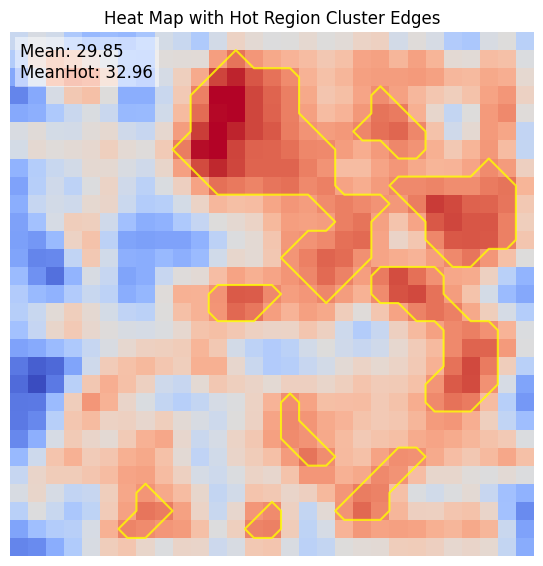

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Heat Map with Hot Region Cluster Edges'}>)

In [3]:
generate_heat_island_map(temp_matrix, temp_matrix, threshold=32, show=True)


In [3]:
def random_insertion(type_matrix, budget_max, type_to_num, tree_species, cost_factor=1.5):
    H, W = type_matrix.shape
    placed_elements = []
    total_cost = 0
    min_tree_cost = min(tree_species[t]['base_price'] for t in tree_species)
    used_cells = set()
    max_iterations = H * W * 10
    iterations = 0

    while total_cost + min_tree_cost <= budget_max and iterations < max_iterations:
        iterations += 1
        row = random.randint(0, H - 1)
        col = random.randint(0, W - 1)

        if type_matrix[row, col] == type_to_num['building'] or (row, col) in used_cells:
            continue

        species = random.choice(list(tree_species.keys()))
        cell_factor = cost_factor if type_matrix[row, col] == type_to_num['road'] else 1.0
        cost = tree_species[species]['base_price'] * cell_factor

        if total_cost + cost > budget_max:
            continue

        placed_elements.append((row, col, species))
        used_cells.add((row, col))
        total_cost += cost

    return placed_elements

In [14]:
random_solution = random_insertion(type_matrix, budget_max, type_to_num, tree_species)

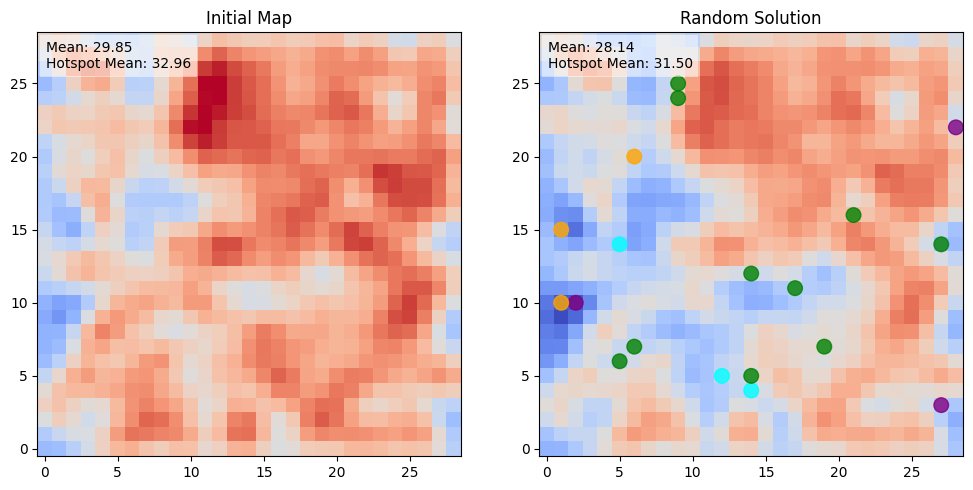

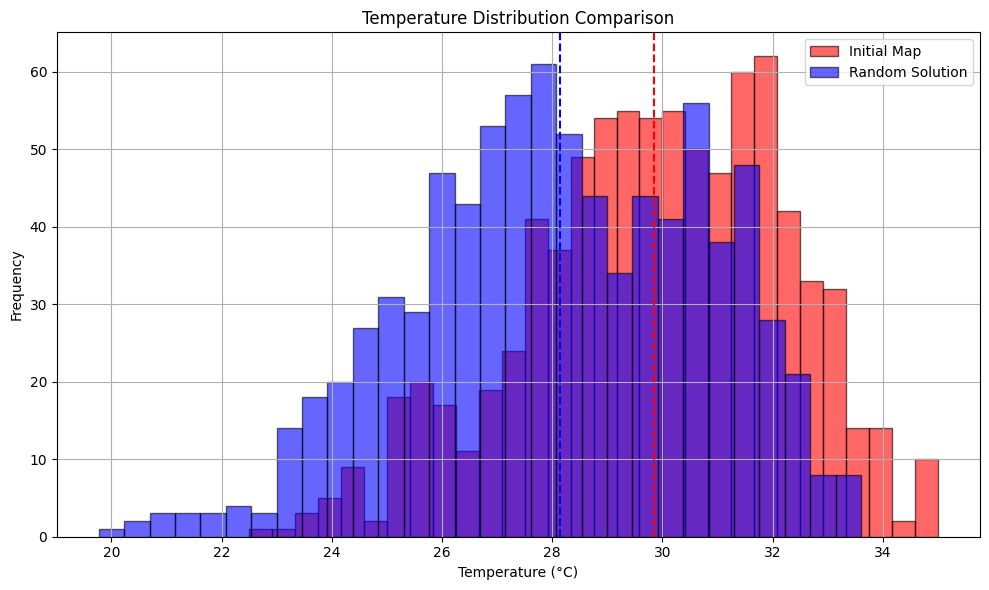

In [15]:
compare_solution_heatmaps([], random_solution, temp_matrix, tree_species,
                          title1="Initial Map", title2="Random Solution")


Genetic algorithm

In [5]:
# ===========================
# 5. Optimization - Genetic Algorithm
# ===========================
def run_ga(type_matrix, temp_matrix, budget_max, type_to_num, tree_species,
           pop_size=300, max_iter=150, mutation_prob=0.1):
  
    # --- GA Parameters ---
    dim = 4 * 50  # example: 50 max placements (row, col, species, active_flag)
    varbound = []
    H, W = type_matrix.shape

    for _ in range(50):
        varbound.extend([
            (0, H - 1),        # row
            (0, W - 1),        # col
            (0, len(tree_species) - 1),  # species
            (0, 1)             # active flag
        ])
    varbound = np.array(varbound)

    # --- Objective Function Wrapper ---
    def ga_objective(X):
        solution = []
        for i in range(0, len(X), 4):
            if int(X[i + 3]) == 1:  # active
                row = int(X[i])
                col = int(X[i + 1])
                species = int(X[i + 2])
                solution.append((row, col, species))
        return objective_function(solution, type_matrix, temp_matrix, tree_species,
                                  type_to_num, budget_max)

    # --- Run GA ---
    model = ga(
        function=ga_objective,
        dimension=dim,
        variable_type='int',
        variable_boundaries=varbound,
        algorithm_parameters={
            'max_num_iteration': max_iter,
            'population_size': pop_size,
            'mutation_probability': mutation_prob,
            'elit_ratio': 0.1,
            'crossover_probability': 0.7,
            'parents_portion': 0.3,
            'crossover_type': 'uniform',
            'max_iteration_without_improv': 10
        }
    )

    model.run()
    return model


ACO Algorithm

In [ ]:
# ===========================
# 7. ACO - Ant Colony Optimization
# ===========================
def update_pos_pheromone(best_solution, pheromone, evaporation_rate=0.05, reinforcement=0.3):
    pheromone *= (1 - evaporation_rate)
    for (row, col, species) in best_solution:
        pheromone[row, col] += reinforcement
    return pheromone


def update_cand_pheromone(best_solution, candidate_pheromone, evaporation_rate=0.05, reinforcement=0.01):
    candidate_pheromone *= (1 - evaporation_rate)
    for (_, _, species) in best_solution:
        candidate_pheromone[species] += reinforcement
    return candidate_pheromone


def probabilistic_selection(type_matrix, pheromone, candidate_pheromone, budget_remaining, cost_factor, type_to_num):
    feasible_choices = []
    H, W = type_matrix.shape

    for row in range(H):
        for col in range(W):
            if type_matrix[row, col] == type_to_num['building']:
                continue
            cell_factor = cost_factor if type_matrix[row, col] == type_to_num['road'] else 1.0
            for species in range(len(tree_species)):
                cost = tree_species[species]['base_price'] * cell_factor
                if cost <= budget_remaining:
                    prob = pheromone[row, col] * candidate_pheromone[species]
                    feasible_choices.append((species, (row, col), prob))

    if not feasible_choices:
        return None, None

    candidate_types, indices, probabilities = zip(*feasible_choices)
    chosen_idx = random.choices(range(len(feasible_choices)), weights=probabilities, k=1)[0]
    return candidate_types[chosen_idx], indices[chosen_idx]


def run_aco(type_matrix, temp_matrix, type_to_num, budget_max, iterations=100, num_ants=30, cost_factor=1.5,
            evaporation_rate_pos=0.2, reinforcement_pos=0.3, evaporation_rate_cand=0.05, reinforcement_cand=0.01,
            use_cand_pheromone=False):

    H, W = type_matrix.shape
    pheromone = np.ones((H, W))
    candidate_pheromone = np.ones(len(tree_species))

    min_candidate_cost = min(tree_species[t]['base_price'] for t in tree_species)
    best_solution = []
    best_quality = float('inf')

    for _ in range(iterations):
        for _ in range(num_ants):
            solution = []
            budget_remaining = budget_max
            used_cells = set()

            while budget_remaining >= min_candidate_cost:
                species, pos = probabilistic_selection(type_matrix, pheromone, candidate_pheromone, budget_remaining, cost_factor, type_to_num)
                if species is None or pos in used_cells:
                    break
                row, col = pos
                cost = tree_species[species]['base_price']
                cell_factor = cost_factor if type_matrix[row, col] == type_to_num['road'] else 1.0
                cost *= cell_factor

                if budget_remaining >= cost:
                    solution.append((row, col, species))
                    used_cells.add(pos)
                    budget_remaining -= cost

            cooled = apply_cooling(solution, temp_matrix, tree_species)
            avg_temp = np.mean(cooled)
            max_temp = np.max(cooled)
            objective_value = avg_temp + 0.5 * max_temp

            if objective_value < best_quality:
                best_solution = solution
                best_quality = objective_value

        pheromone = update_pos_pheromone(best_solution, pheromone, evaporation_rate_pos, reinforcement_pos)
        if use_cand_pheromone:
            candidate_pheromone = update_cand_pheromone(best_solution, candidate_pheromone, evaporation_rate_cand, reinforcement_cand)

    return best_solution

Multiple run function

In [7]:
def evaluate_multiple_runs(runs, type_matrix, temp_matrix, budget_max, type_to_num, tree_species):
    """
    Executes multiple runs of Random, GA, ACO, and ACO + Candidate Pheromone optimization.
    Returns statistics: [(budget used, avg temp, avg hotspot temp)]
    """

    stats = [[], [], [], []]
    algorithms = ['Random Insertion', 'GA', 'ACO', 'ACO + Cand Ph']

    for run in range(runs):
        print(f"\n--- Run {run + 1} ---")

        # === Random Insertion ===
        random_sol = random_insertion(type_matrix, budget_max, type_to_num, tree_species)
        budget = calculate_used_budget(random_sol, type_matrix, tree_species, type_to_num)
        avg, avg_hotspot = calculate_objective_stats(
            calculate_reduced_heatmap(random_sol, temp_matrix, tree_species), temp_matrix)
        stats[0].append((budget, avg, avg_hotspot))

        # === GA ===
        model = run_ga(type_matrix, temp_matrix, budget_max, type_to_num, tree_species)
        ga_sol = [(int(model.output_dict['variable'][j]),
                  int(model.output_dict['variable'][j + 1]),
                  int(model.output_dict['variable'][j + 2]))
                 for j in range(0, len(model.output_dict['variable']), 4)
                 if int(model.output_dict['variable'][j + 3]) == 1]
        budget = calculate_used_budget(ga_sol, type_matrix, tree_species, type_to_num)
        avg, avg_hotspot = calculate_objective_stats(
            calculate_reduced_heatmap(ga_sol, temp_matrix, tree_species), temp_matrix)
        stats[1].append((budget, avg, avg_hotspot))

        # === ACO ===
        aco_sol = run_aco(type_matrix, temp_matrix, type_to_num, budget_max,
                          iterations=50, num_ants=10)
        budget = calculate_used_budget(aco_sol, type_matrix, tree_species, type_to_num)
        avg, avg_hotspot = calculate_objective_stats(
            calculate_reduced_heatmap(aco_sol, temp_matrix, tree_species), temp_matrix)
        stats[2].append((budget, avg, avg_hotspot))

        # === ACO + Candidate Pheromone ===
        aco_cand_sol = run_aco(type_matrix, temp_matrix, type_to_num, budget_max,
                               iterations=50, num_ants=10, use_cand_pheromone=True)
        budget = calculate_used_budget(aco_cand_sol, type_matrix, tree_species, type_to_num)
        avg, avg_hotspot = calculate_objective_stats(
            calculate_reduced_heatmap(aco_cand_sol, temp_matrix, tree_species), temp_matrix)
        stats[3].append((budget, avg, avg_hotspot))

    print("\n✅ Evaluation completed.")
    return stats




 The best solution found:                                                                           
 [13. 20.  0.  1. 24. 15.  0.  0.  6. 10.  0.  1. 10. 16.  0.  0. 15. 16.
  0.  0. 16. 16.  3.  1. 14. 15.  2.  0. 18.  5.  0.  1. 20. 26.  1.  0.
 12.  5.  3.  1. 17. 20.  0.  1. 24. 11.  0.  0. 17.  7.  2.  0. 16. 19.
  0.  1. 24. 21.  0.  0. 15. 19.  2.  0. 21. 28.  2.  0. 15. 24.  0.  1.
 12.  7.  1.  1. 25. 11.  1.  0.  9.  5.  0.  1. 11. 22.  0.  0. 27.  5.
  1.  0.  7. 21.  2.  0. 10. 12.  0.  0.  4. 28.  1.  0. 21. 27.  0.  1.
 23. 16.  3.  1.  6.  8.  0.  1.  6. 17.  1.  0. 15. 10.  0.  0. 11. 17.
  2.  0.  1. 16.  1.  1.  7.  6.  2.  1. 25.  6.  1.  0. 28. 24.  0.  0.
 12. 21.  0.  1. 26. 28.  1.  0. 11.  0.  3.  0.  2.  2.  0.  0. 21. 16.
  0.  0. 26.  4.  1.  0. 21. 22.  0.  1. 24. 20.  3.  0. 28.  3.  1.  0.
 27.  4.  0.  0.  6. 16.  3.  0. 18.  7.  2.  0. 25. 13.  1.  0. 21. 23.
  3.  0.]

 Objective function:
 41.88271967527987


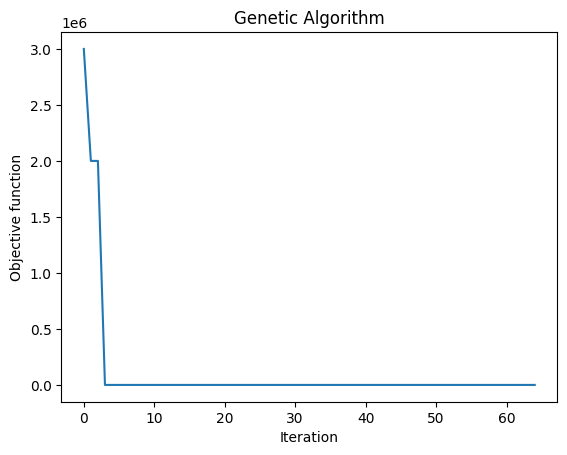

In [8]:
model = run_ga(type_matrix, temp_matrix, budget_max, type_to_num, tree_species)

ga_solution = [(int(model.output_dict['variable'][j]),
                  int(model.output_dict['variable'][j + 1]),
                  int(model.output_dict['variable'][j + 2]))
                 for j in range(0, len(model.output_dict['variable']), 4)
                 if int(model.output_dict['variable'][j + 3]) == 1]


In [9]:
print_solution_elements(ga_solution,heading='Single Run Result (25/75 Weighting)')
print("Total cost:", calculate_used_budget(ga_solution, type_matrix, tree_species, type_to_num))



--- Single Run Result (25/75 Weighting) ---
Number of placements: 17
Type: tree_1 at Position: (13, 20)
Type: tree_1 at Position: (6, 10)
Type: tree_4 at Position: (16, 16)
Type: tree_1 at Position: (18, 5)
Type: tree_4 at Position: (12, 5)
Type: tree_1 at Position: (17, 20)
Type: tree_1 at Position: (16, 19)
Type: tree_1 at Position: (15, 24)
Type: tree_2 at Position: (12, 7)
Type: tree_1 at Position: (9, 5)
Type: tree_1 at Position: (21, 27)
Type: tree_4 at Position: (23, 16)
Type: tree_1 at Position: (6, 8)
Type: tree_2 at Position: (1, 16)
Type: tree_3 at Position: (7, 6)
Type: tree_1 at Position: (12, 21)
Type: tree_1 at Position: (21, 22)
Total cost: 1455.0


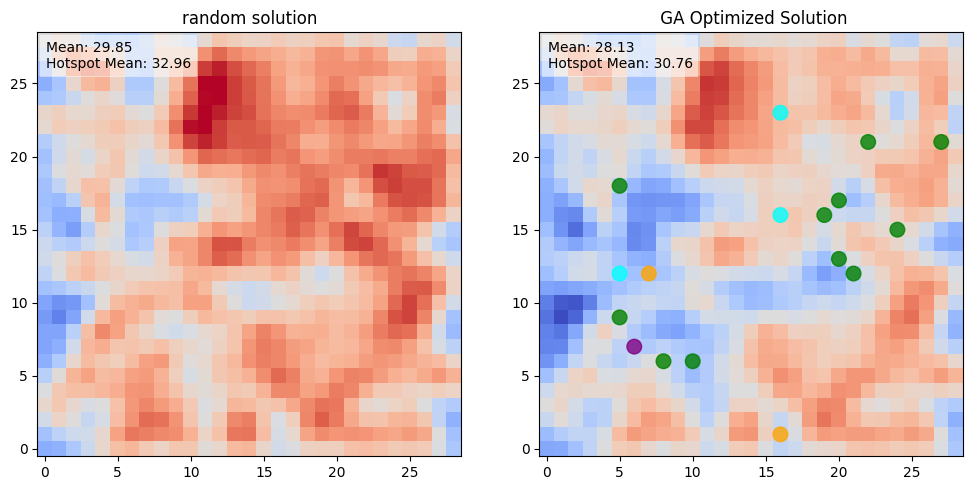

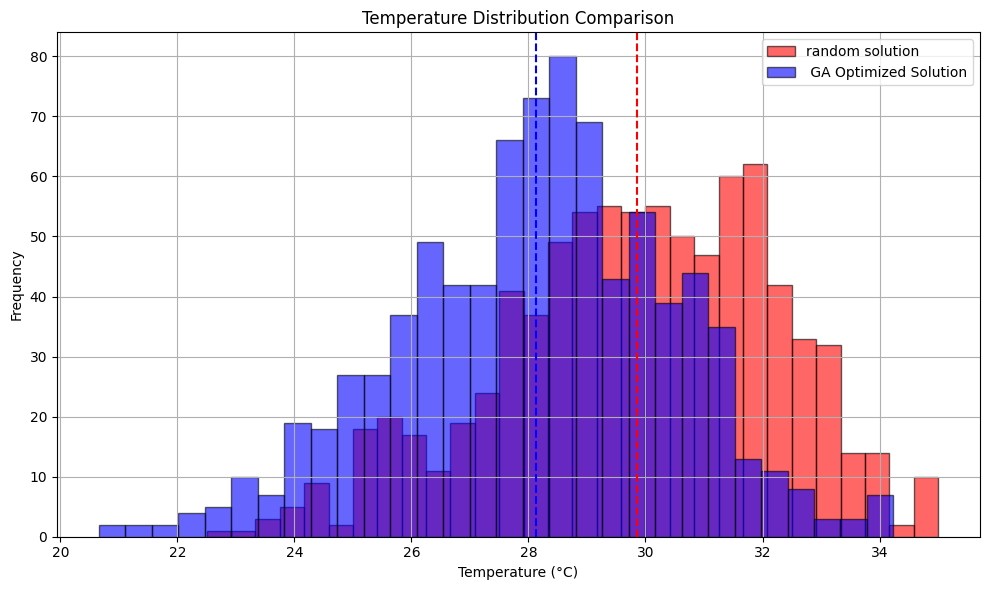

In [10]:
compare_solution_heatmaps([], ga_solution, temp_matrix, tree_species,
                          title1="random solution", title2=" GA Optimized Solution")


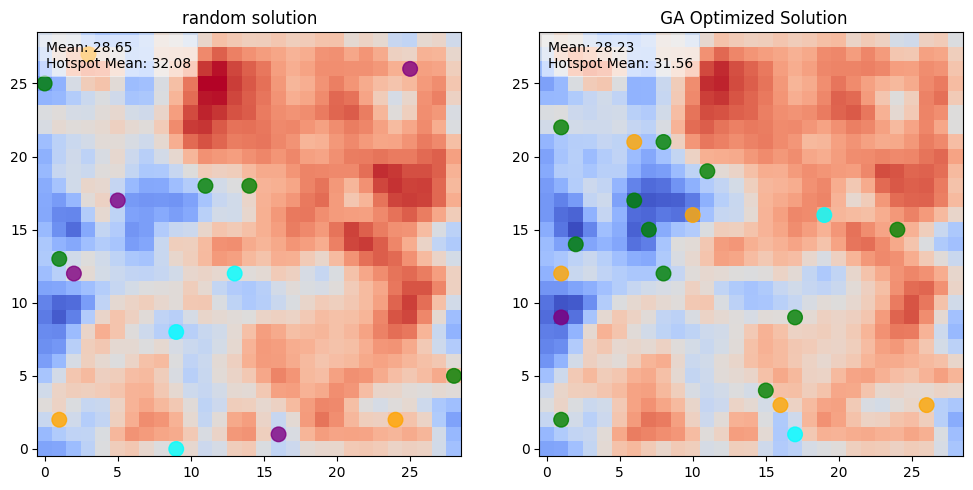

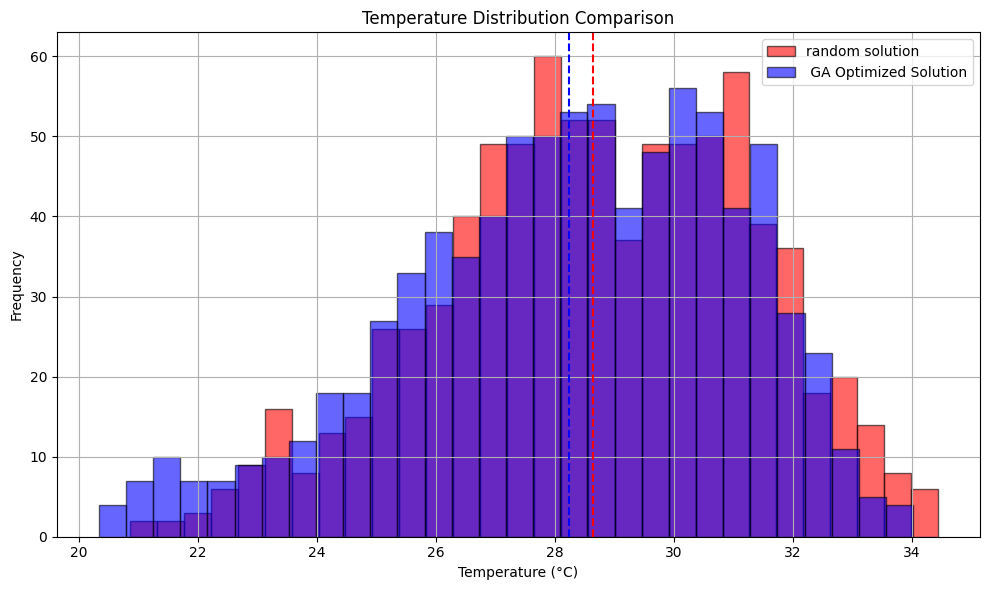

In [ ]:
compare_solution_heatmaps(random_solution, ga_solution, temp_matrix, tree_species,
                          title1="random solution", title2=" GA Optimized Solution")


In [17]:
aco_solution = run_aco(type_matrix, temp_matrix, type_to_num, budget_max, iterations=100, num_ants=10)


In [18]:
print_solution_elements(aco_solution, heading='ACO Result')
print("Total cost:", calculate_used_budget(aco_solution, type_matrix, tree_species, type_to_num))
aco_heatmap = calculate_reduced_heatmap(aco_solution, temp_matrix, tree_species)


--- ACO Result ---
Number of placements: 18
Type: tree_1 at Position: (14, 4)
Type: tree_4 at Position: (0, 8)
Type: tree_1 at Position: (16, 8)
Type: tree_2 at Position: (10, 3)
Type: tree_1 at Position: (5, 0)
Type: tree_2 at Position: (8, 5)
Type: tree_1 at Position: (14, 7)
Type: tree_3 at Position: (28, 25)
Type: tree_2 at Position: (10, 15)
Type: tree_2 at Position: (12, 14)
Type: tree_3 at Position: (5, 3)
Type: tree_4 at Position: (7, 26)
Type: tree_1 at Position: (24, 25)
Type: tree_1 at Position: (28, 9)
Type: tree_1 at Position: (13, 26)
Type: tree_3 at Position: (14, 1)
Type: tree_3 at Position: (1, 10)
Type: tree_1 at Position: (19, 7)
Total cost: 1495.0


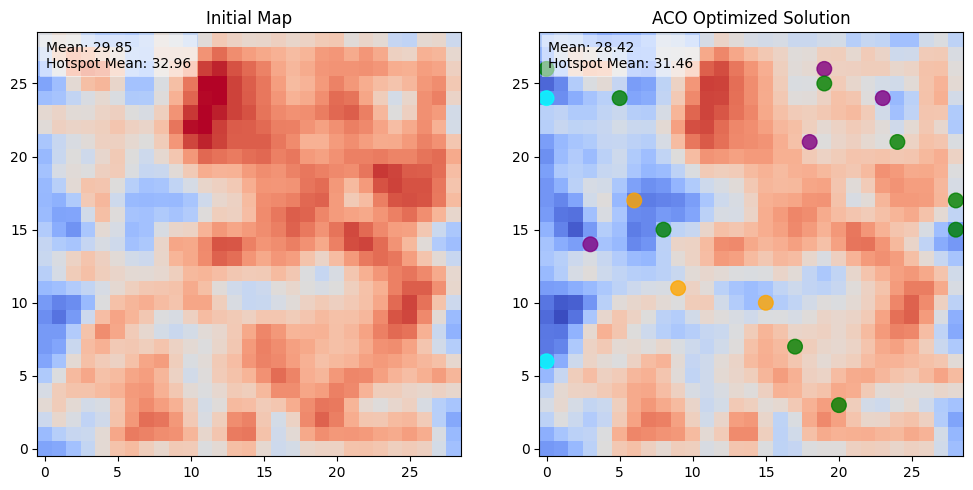

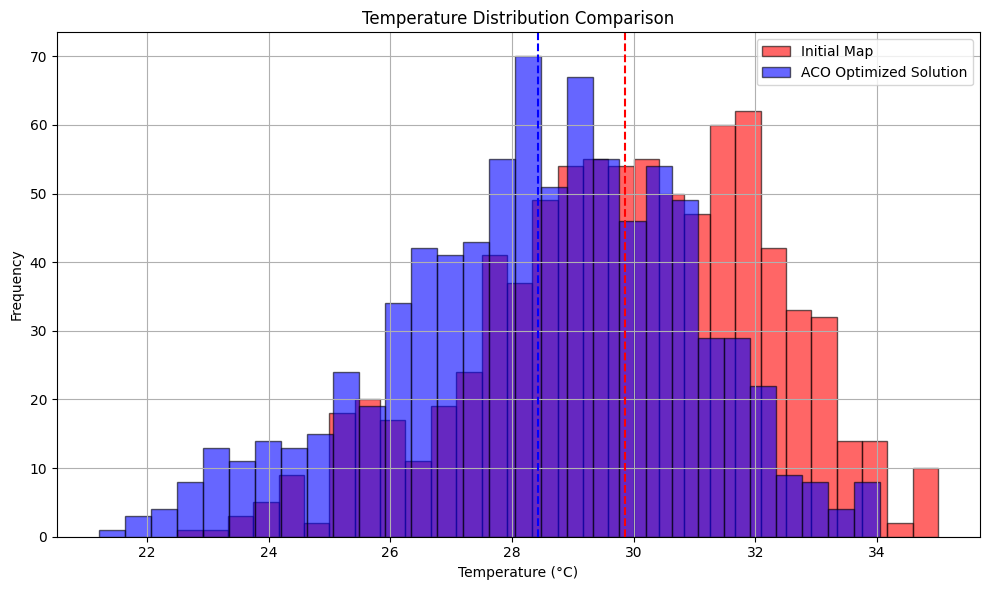

In [ ]:
compare_solution_heatmaps([], aco_solution, temp_matrix, tree_species,
                          title1="Initial Map", title2="ACO Optimized Solution")


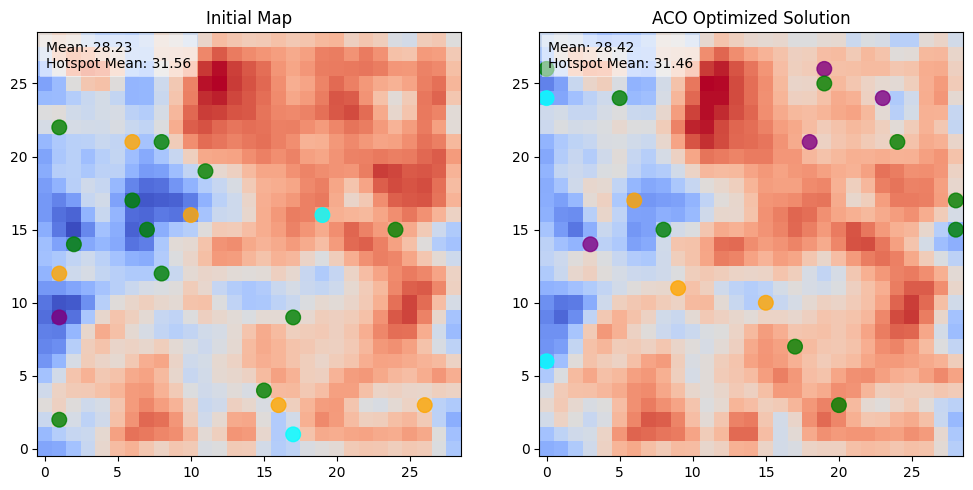

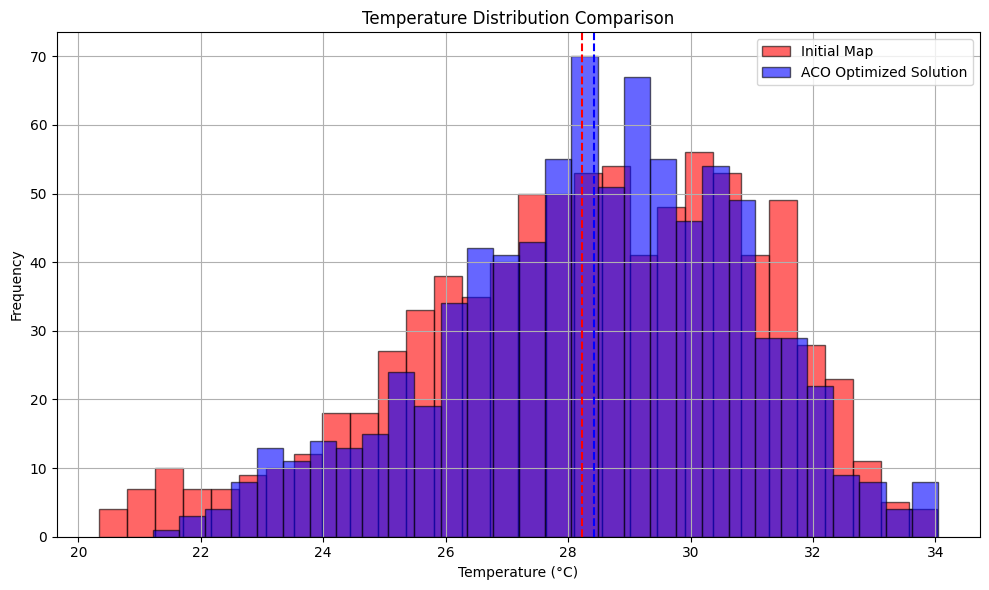

In [ ]:
# Plot comparison of temperature maps for GA and ACO solutions
compare_solution_heatmaps(ga_solution, aco_solution, temp_matrix, tree_species,
                          title1="Initial Map", title2="ACO Optimized Solution")



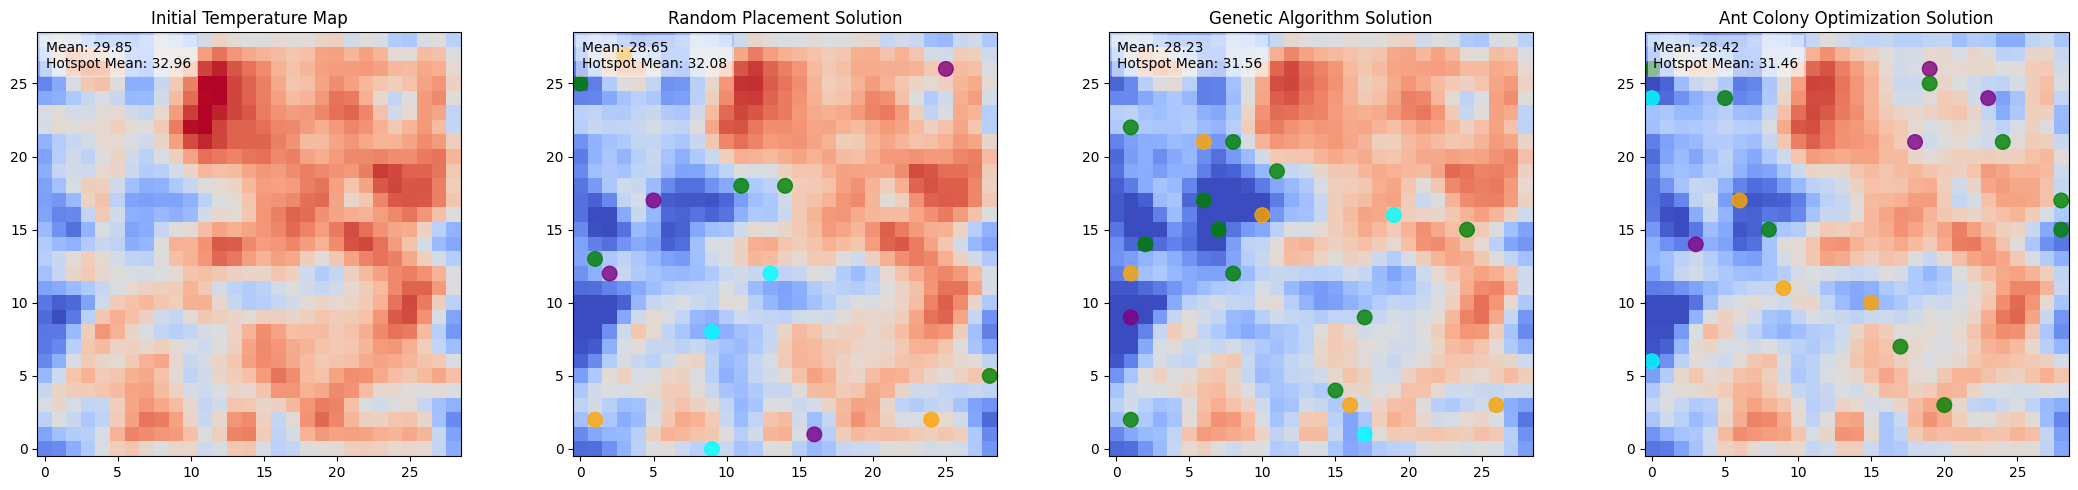

In [ ]:
# Plot comparison of temperature maps for initial, random, GA, and ACO solutions
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

# Initial temperature map
generate_heatmap(temp_matrix, vmin=vmin, vmax=vmax, show=False, ax=axs[0])
avg_temp, avg_hotspot_temp = calculate_objective_stats(temp_matrix, temp_matrix)
axs[0].set_title("Initial Temperature Map")
axs[0].text(0.02, 0.98, f"Mean: {avg_temp:.2f}\nHotspot Mean: {avg_hotspot_temp:.2f}",
            transform=axs[0].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# Random solution temperature map
random_temp = calculate_reduced_heatmap(random_solution, temp_matrix, tree_species)
generate_heatmap(random_temp, vmin=vmin, vmax=vmax, show=False, ax=axs[1])
avg_temp, avg_hotspot_temp = calculate_objective_stats(random_temp, temp_matrix)
axs[1].set_title("Random Placement Solution")
axs[1].text(0.02, 0.98, f"Mean: {avg_temp:.2f}\nHotspot Mean: {avg_hotspot_temp:.2f}",
            transform=axs[1].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
for (row, col, species) in random_solution:
    axs[1].add_patch(plt.Circle((col, row), radius=0.5, color=tree_species[species]['color'], alpha=0.8))

# GA solution temperature map
ga_temp = calculate_reduced_heatmap(ga_solution, temp_matrix, tree_species)
generate_heatmap(ga_temp, vmin=vmin, vmax=vmax, show=False, ax=axs[2])
avg_temp, avg_hotspot_temp = calculate_objective_stats(ga_temp, temp_matrix)
axs[2].set_title("Genetic Algorithm Solution")
axs[2].text(0.02, 0.98, f"Mean: {avg_temp:.2f}\nHotspot Mean: {avg_hotspot_temp:.2f}",
            transform=axs[2].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
for (row, col, species) in ga_solution:
    axs[2].add_patch(plt.Circle((col, row), radius=0.5, color=tree_species[species]['color'], alpha=0.8))

# ACO solution temperature map
aco_temp = calculate_reduced_heatmap(aco_solution, temp_matrix, tree_species)
generate_heatmap(aco_temp, vmin=vmin, vmax=vmax, show=False, ax=axs[3])
avg_temp, avg_hotspot_temp = calculate_objective_stats(aco_temp, temp_matrix)
axs[3].set_title("Ant Colony Optimization Solution")
axs[3].text(0.02, 0.98, f"Mean: {avg_temp:.2f}\nHotspot Mean: {avg_hotspot_temp:.2f}",
            transform=axs[3].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
for (row, col, species) in aco_solution:
    axs[3].add_patch(plt.Circle((col, row), radius=0.5, color=tree_species[species]['color'], alpha=0.8))

plt.tight_layout()
plt.show()


--- Run 1 ---
 The best solution found:                                                                           
 [ 8. 10.  3.  0.  9.  2.  2.  0. 25.  6.  3.  0. 24. 16.  1.  0. 19.  8.
  0.  0. 17. 27.  1.  0. 17. 17.  3.  1. 27. 21.  1.  0.  5. 19.  1.  1.
 16. 10.  0.  0. 12. 10.  1.  0. 26.  9.  1.  1. 24.  8.  3.  0. 17.  6.
  2.  1.  1. 25.  1.  0. 25. 11.  1.  0. 15. 27.  2.  0. 20. 19.  0.  1.
 24.  7.  3.  0. 12.  7.  0.  0.  2. 10.  2.  0. 22. 28.  0.  1. 25. 22.
  1.  0. 20.  8.  0.  1. 21.  1.  2.  0. 16. 16.  0.  1.  7. 11.  1.  0.
 17. 14.  0.  1. 15. 21.  1.  0. 11.  6.  1.  0. 16. 19.  0.  1. 12. 15.
  2.  1. 25. 16.  0.  0. 15. 27.  1.  0. 21. 24.  1.  1.  4. 13.  3.  0.
 11. 14.  3.  0. 27. 21.  1.  0. 20.  2.  1.  0. 10.  9.  0.  0.  0. 20.
  1.  0.  3. 27.  3.  1. 15. 25.  0.  1. 28. 12.  2.  1. 12. 25.  2.  1.
 24. 16.  2.  0. 28.  5.  1.  0. 10. 10.  3.  0.  0.  7.  0.  0.  7.  4.
  3.  0.]

 Objective function:
 42.05754742111065


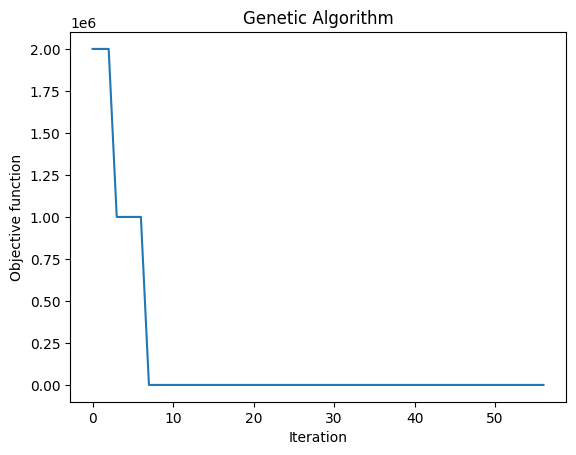


--- Run 2 ---
 The best solution found:                                                                           
 [14.  1.  1.  0.  9.  4.  3.  0.  9. 17.  2.  1. 26. 20.  2.  0. 22. 27.
  1.  1. 12. 20.  3.  1.  3.  6.  0.  0. 17. 21.  3.  1.  5. 20.  1.  0.
 11. 20.  0.  1. 20. 15.  0.  1.  7. 17.  3.  1. 27. 19.  1.  0. 14. 15.
  2.  0. 14. 24.  2.  0.  8.  9.  3.  0. 16. 16.  1.  0. 19. 26.  3.  0.
  3.  6.  3.  1.  9. 18.  1.  0. 18.  5.  0.  0.  4. 18.  0.  1. 12. 19.
  1.  0. 19.  9.  3.  0. 17.  6.  3.  0. 26. 16.  0.  1. 21. 15.  1.  0.
  7. 23.  2.  0. 18. 12.  1.  0. 22. 13.  3.  0.  0. 15.  2.  1. 10. 21.
  2.  0. 18.  5.  0.  1.  7.  6.  2.  0. 26. 14.  2.  0. 28.  9.  1.  0.
  8. 27.  0.  0. 19. 15.  0.  1. 13. 26.  2.  1. 13. 16.  0.  0. 28. 18.
  1.  0. 14. 16.  1.  0. 13. 21.  2.  0. 21.  3.  0.  0. 11. 26.  3.  0.
  5. 26.  0.  0. 25. 25.  1.  0. 28. 21.  1.  0. 15.  1.  1.  0.  2.  5.
  3.  0.]

 Objective function:
 42.25482680042555


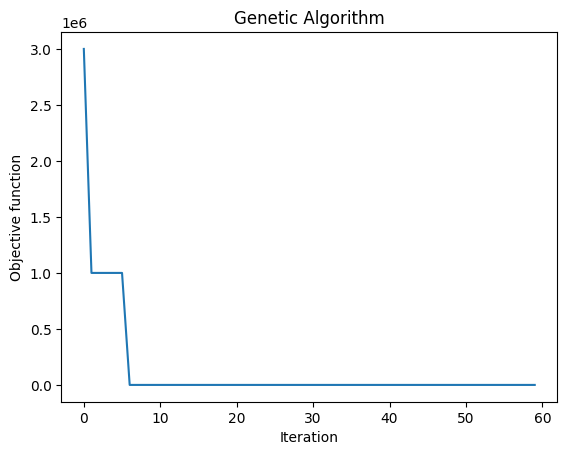


--- Run 3 ---
 The best solution found:                                                                           
 [27. 23.  0.  0. 12. 11.  2.  0. 10. 19.  0.  1. 17. 21.  1.  1.  9. 15.
  1.  0. 24. 24.  2.  1. 14. 24.  0.  0. 11. 21.  3.  1. 17. 17.  0.  1.
  9. 20.  3.  0.  6.  0.  1.  0. 13.  4.  0.  1. 27. 27.  0.  0.  5. 21.
  3.  0. 25. 22.  1.  0. 16.  6.  1.  1. 10. 14.  0.  0.  8.  9.  0.  1.
  9. 18.  0.  0. 17. 26.  0.  1. 18.  9.  1.  1. 19.  3.  3.  0.  5. 10.
  2.  0. 22.  0.  0.  0. 26.  6.  1.  0.  9.  6.  2.  0.  0. 23.  0.  1.
  6. 13.  0.  0.  2. 16.  2.  0. 18. 21.  2.  1. 21. 22.  2.  0. 12. 10.
  3.  1. 17.  8.  0.  1. 17. 11.  3.  0. 15. 16.  3.  0. 25.  4.  0.  0.
 13. 20.  3.  0. 14. 25.  2.  0.  5.  2.  2.  0.  1.  1.  2.  0.  9. 18.
  0.  0.  7.  7.  3.  0. 17. 10.  0.  1. 21. 26.  2.  0.  2.  0.  2.  0.
 12.  0.  0.  0.  9. 25.  0.  0. 12. 26.  3.  0. 27. 26.  3.  1.  2. 17.
  2.  0.]

 Objective function:
 42.24042245562991


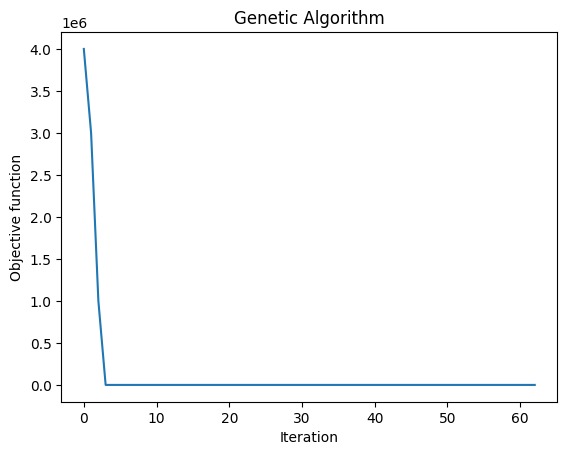


--- Run 4 ---
 The best solution found:                                                                           
 [19. 16.  0.  0. 14.  5.  3.  0.  3. 14.  0.  0. 10.  6.  2.  0. 10. 20.
  0.  0. 15. 14.  3.  1. 12. 23.  3.  1. 17.  5.  1.  1. 25. 23.  2.  0.
 25. 24.  0.  0. 10.  6.  3.  0. 14. 24.  0.  0.  6. 11.  0.  0.  3. 12.
  0.  0. 24. 25.  2.  0.  0. 11.  0.  0.  2. 13.  2.  0. 24. 14.  1.  0.
 27. 12.  3.  0. 18. 14.  2.  0.  7. 17.  1.  1. 14.  5.  0.  0. 10.  2.
  1.  0.  3.  8.  0.  0.  3.  1.  0.  0. 11. 20.  2.  1.  8. 10.  1.  1.
 28.  7.  1.  1.  5. 19.  0.  1. 18. 24.  0.  0. 23.  1.  1.  0.  2. 20.
  2.  0. 17.  9.  3.  1. 13.  7.  1.  0. 17. 13.  2.  1.  7.  1.  3.  1.
 15. 22.  2.  0. 12. 18.  2.  0. 10.  2.  1.  0. 14.  4.  2.  1.  7. 20.
  0.  0. 16.  9.  1.  1. 26.  7.  3.  1. 23. 23.  2.  0.  8.  4.  0.  0.
 10.  6.  1.  0.  6.  0.  0.  0. 15. 23.  0.  0.  5. 16.  1.  0.  1.  2.
  3.  0.]

 Objective function:
 42.646581349904025


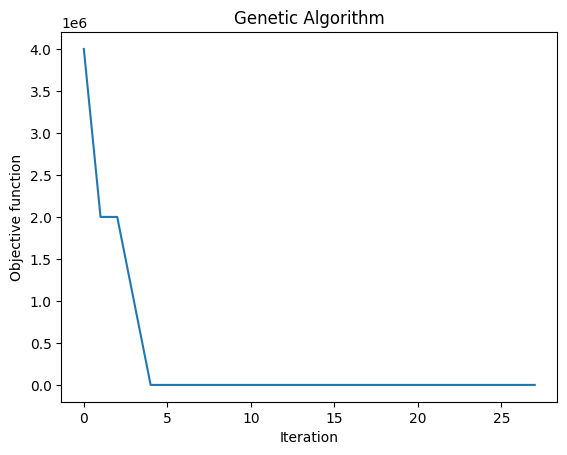


--- Run 5 ---
 The best solution found:                                                                           
 [27. 16.  0.  0. 23. 25.  0.  1. 18. 14.  0.  1. 27. 14.  0.  1. 23. 19.
  3.  1. 25. 15.  2.  0.  5. 20.  0.  0.  2.  7.  3.  0.  7. 11.  1.  0.
 10. 11.  2.  0. 11.  1.  1.  1. 19.  9.  3.  1.  7. 28.  0.  1. 14.  5.
  3.  0. 17. 21.  3.  1.  2.  7.  1.  0. 13.  6.  3.  1. 21.  8.  0.  0.
 10. 20.  2.  0. 23. 11.  3.  0. 27.  9.  3.  0. 20. 17.  0.  1. 15. 12.
  2.  0. 14. 22.  1.  0. 12. 24.  2.  0.  6.  5.  1.  0. 16.  7.  2.  0.
  9. 25.  0.  0. 21. 11.  0.  0. 27.  0.  1.  0. 16. 23.  0.  1. 25. 25.
  0.  0.  7. 13.  2.  0.  6. 17.  2.  0. 20. 25.  2.  0. 17. 15.  2.  0.
 14. 18.  2.  0.  3. 17.  2.  0. 17. 15.  0.  1.  9. 22.  1.  0. 11.  5.
  2.  0. 18. 18.  1.  1. 16.  2.  2.  1.  7. 15.  2.  0. 19. 13.  2.  1.
  8.  8.  0.  1. 22.  5.  3.  0. 28. 15.  0.  0.  1. 16.  0.  1. 13. 10.
  2.  0.]

 Objective function:
 41.72126156934089


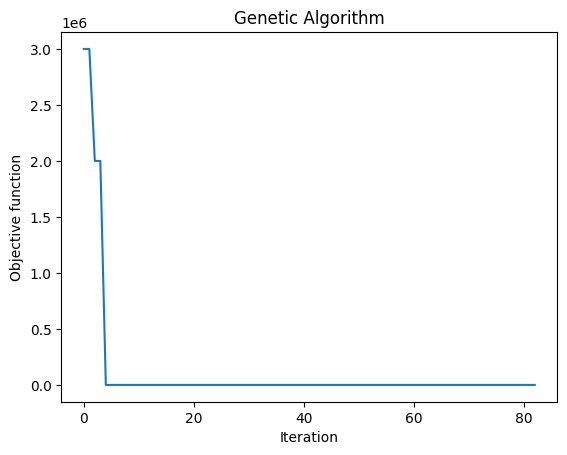


--- Run 6 ---
 The best solution found:                                                                           
 [14. 18.  0.  0. 28. 12.  1.  0. 27. 16.  2.  0. 16. 27.  1.  0. 22. 25.
  2.  0. 17. 21.  2.  0. 20.  0.  0.  0. 13. 19.  2.  1. 12. 28.  1.  0.
  1. 19.  3.  1.  7. 24.  1.  0. 15. 15.  0.  0. 10. 26.  3.  0. 26.  6.
  0.  1. 21. 25.  3.  0. 22. 21.  3.  1. 12. 28.  3.  1.  9.  2.  1.  0.
  7. 17.  1.  0. 28. 27.  3.  0.  9.  7.  2.  0. 15. 11.  0.  1.  1. 25.
  0.  0. 15.  5.  3.  1. 19. 15.  0.  1. 10. 15.  1.  0.  4.  6.  2.  0.
  7.  1.  0.  0. 27.  4.  2.  1. 15. 28.  2.  0.  0. 20.  2.  0. 27.  9.
  1.  1.  7. 18.  2.  0. 14. 13.  2.  0. 20.  3.  3.  0.  3. 23.  3.  0.
 14. 18.  2.  0. 23. 24.  1.  1.  3.  1.  2.  0.  0. 25.  2.  0.  8. 21.
  0.  1. 17. 21.  0.  1. 20.  5.  3.  0. 27. 18.  1.  0. 18. 18.  2.  1.
  0. 22.  2.  0. 25. 20.  2.  0.  4.  3.  3.  0.  5. 28.  0.  0. 18. 18.
  1.  0.]

 Objective function:
 42.38801026620331


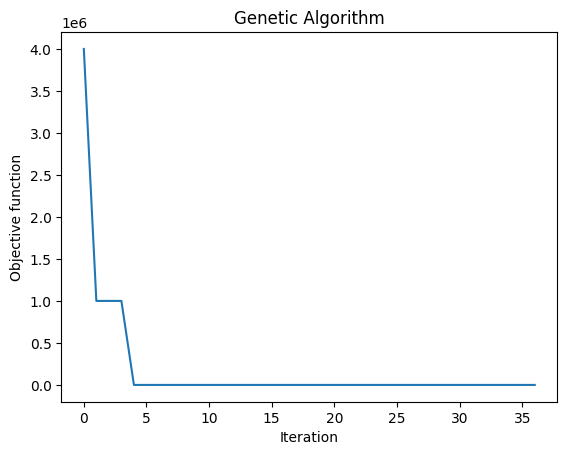


--- Run 7 ---
 The best solution found:                                                                           
 [ 9. 21.  3.  0. 20. 28.  3.  0. 27.  6.  2.  1.  2.  8.  3.  0.  0. 16.
  2.  0.  9.  7.  2.  0.  9. 18.  0.  1. 21. 18.  2.  1.  3. 22.  1.  0.
 19.  6.  0.  0.  3.  5.  0.  0. 17. 12.  2.  0. 16.  5.  3.  0. 13. 25.
  0.  0.  3.  8.  3.  1. 12. 16.  1.  0. 26.  7.  3.  1. 20.  3.  3.  0.
  5. 28.  1.  0. 24. 14.  3.  1. 25. 19.  2.  0.  9. 21.  1.  0. 25. 26.
  1.  0. 19. 28.  2.  0.  6. 20.  2.  1.  4. 16.  0.  0. 11. 14.  0.  1.
  4. 23.  0.  0. 19.  4.  0.  0. 14.  1.  2.  1. 16. 15.  1.  0. 17. 23.
  0.  0. 11.  5.  0.  0. 24.  8.  0.  0.  8. 17.  1.  0. 12.  4.  3.  0.
 27. 25.  3.  0. 22. 18.  0.  0.  4. 16.  0.  0. 12. 16.  0.  1. 28. 25.
  3.  1.  0. 23.  2.  0. 14. 26.  2.  1.  2.  6.  0.  0. 22. 10.  0.  0.
  8.  0.  3.  0.  9. 19.  1.  0.  5. 22.  0.  0.  3. 23.  1.  0. 17. 22.
  2.  1.]

 Objective function:
 42.630176746849024


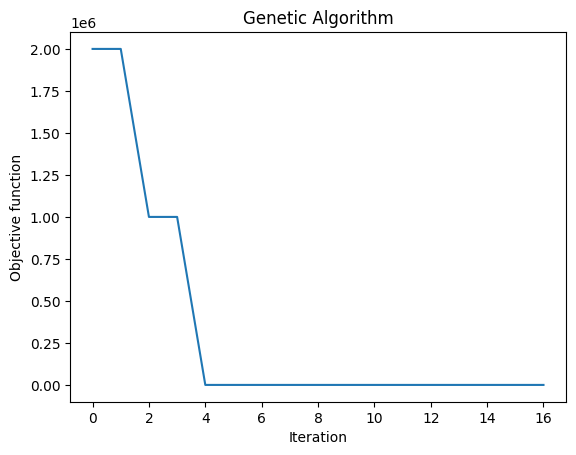


--- Run 8 ---
 The best solution found:                                                                           
 [24.  5.  1.  0. 18. 11.  3.  0. 20.  0.  2.  0. 13. 18.  3.  1. 28. 11.
  1.  0. 12.  1.  0.  1. 16.  6.  3.  0. 10.  3.  3.  0.  2. 22.  1.  0.
 23.  5.  0.  0. 12. 19.  0.  1. 24.  9.  3.  0. 21. 19.  3.  1. 16.  1.
  2.  0.  9. 13.  1.  0. 13. 23.  1.  0. 23. 12.  2.  0. 15. 19.  3.  1.
  8. 22.  1.  0. 18. 13.  3.  0.  9. 23.  1.  0. 27.  4.  3.  1. 17.  3.
  1.  0. 16. 24.  2.  0. 20. 15.  2.  1. 26.  7.  3.  1. 17. 10.  0.  1.
 14. 26.  0.  0. 19.  2.  2.  0.  6. 23.  1.  0. 16. 26.  1.  0. 24. 14.
  2.  1. 12. 22.  0.  1. 24.  3.  0.  0.  9. 27.  1.  1. 14. 22.  0.  0.
  8. 24.  1.  0.  9.  8.  2.  0. 26. 26.  0.  0.  8. 17.  2.  0. 20.  6.
  0.  1.  9.  1.  1.  0. 25. 25.  1.  0. 23.  6.  1.  0. 25.  9.  3.  1.
 19. 10.  0.  1. 10.  7.  2.  0. 14.  8.  0.  0. 18.  7.  0.  0.  4.  0.
  0.  0.]

 Objective function:
 41.89251228669222


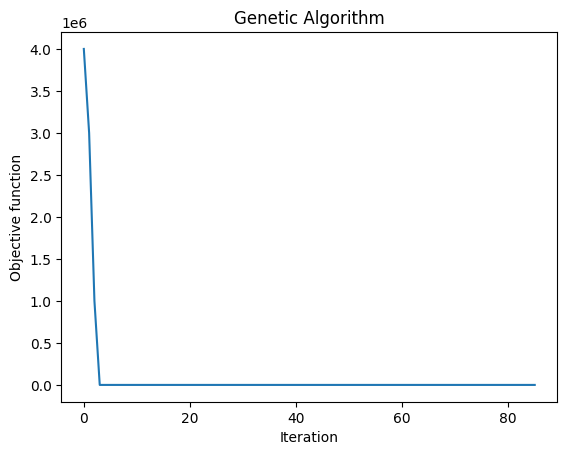


--- Run 9 ---
 The best solution found:                                                                           
 [10. 11.  2.  0. 14. 27.  0.  1. 18.  6.  1.  0. 19. 13.  1.  0.  3. 28.
  0.  1. 21.  0.  2.  0.  6. 28.  3.  0.  3.  7.  0.  0.  0.  1.  3.  0.
 17. 13.  2.  1. 18. 22.  0.  1. 19. 18.  0.  0. 10. 22.  0.  1. 13. 20.
  2.  1. 19.  7.  2.  0. 17. 12.  0.  1.  2.  3.  0.  0.  8. 17.  3.  0.
 12.  1.  0.  0. 24. 21.  0.  0. 21. 28.  1.  0. 17. 20.  0.  1.  7.  0.
  2.  1. 15. 16.  0.  1. 19.  4.  1.  1. 21.  9.  3.  0. 12. 14.  0.  0.
  1.  0.  0.  0.  5.  5.  2.  0. 25.  4.  1.  1. 23.  8.  3.  1. 16. 20.
  0.  0.  6. 15.  1.  0.  9. 15.  0.  0.  2. 18.  1.  0. 26. 26.  3.  0.
 16. 22.  0.  1. 11. 14.  2.  0. 14.  7.  0.  0. 10. 13.  1.  0.  2. 25.
  1.  0. 13.  8.  0.  0. 15. 28.  2.  0. 17. 18.  1.  0. 11. 18.  1.  1.
 25.  2.  3.  0. 12. 22.  2.  0. 14. 27.  2.  0. 28. 18.  2.  0. 14. 10.
  3.  1.]

 Objective function:
 42.11861530169255


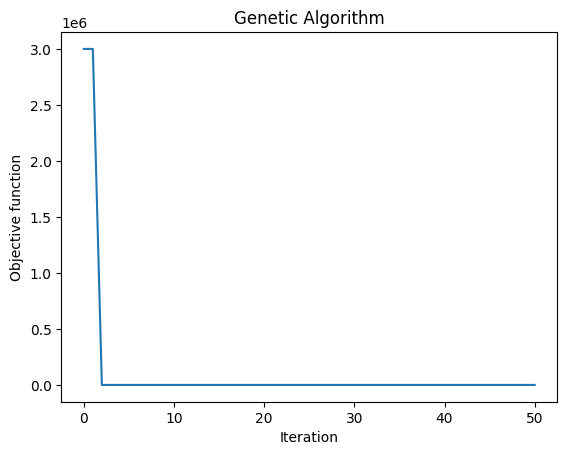


--- Run 10 ---
 The best solution found:                                                                           
 [19.  4.  0.  0. 11. 21.  1.  0. 20.  5.  0.  0. 12. 19.  1.  0.  0.  8.
  0.  1.  4. 18.  3.  0. 26.  1.  1.  0. 23. 16.  3.  1.  6.  5.  0.  0.
 16. 23.  3.  0.  7.  9.  1.  0.  7.  3.  0.  1. 26. 24.  1.  0. 22. 16.
  3.  1. 17. 11.  2.  0. 15.  5.  1.  0. 19. 27.  1.  0.  5.  9.  3.  1.
 25.  6.  2.  0. 12.  9.  0.  0. 20.  5.  1.  0. 18.  7.  2.  0. 24.  9.
  3.  0. 24.  7.  3.  0. 15.  0.  0.  1. 13. 19.  1.  1. 27.  3.  2.  0.
 15.  2.  0.  1.  2. 23.  1.  0. 22. 21.  1.  0. 22.  4.  3.  0. 20.  8.
  0.  1. 13.  7.  3.  0. 27.  5.  3.  0. 20.  6.  1.  1.  8. 13.  2.  0.
 17. 20.  0.  1. 14. 15.  2.  1. 15.  3.  2.  0. 20. 19.  0.  0.  6. 20.
  1.  0. 11. 21.  3.  1.  5.  0.  2.  0. 13. 14.  0.  0. 17. 21.  3.  1.
 12.  8.  1.  0.  1. 17.  3.  1.  5.  8.  0.  0.  2. 14.  3.  0. 10. 11.
  1.  0.]

 Objective function:
 42.11014764335847


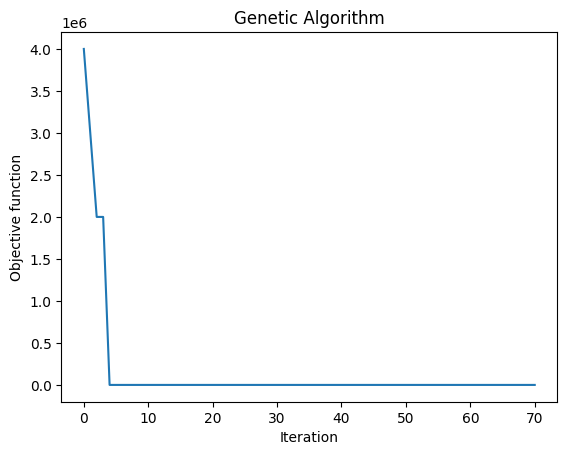


--- Run 11 ---
 The best solution found:                                                                           
 [13.  9.  0.  0.  5. 20.  1.  0. 17.  9.  1.  1.  5. 26.  2.  0. 21. 23.
  1.  0.  1. 14.  2.  0.  1. 22.  1.  0. 18. 26.  1.  0. 28. 14.  2.  1.
  5. 11.  0.  1.  6.  4.  1.  0. 15. 25.  3.  0. 18. 14.  0.  1.  1. 13.
  1.  0. 27. 21.  1.  0.  3. 20.  0.  1.  9. 20.  1.  1. 21. 15.  0.  0.
 27.  6.  2.  1. 21.  6.  0.  1. 20. 19.  0.  1. 20.  6.  3.  0. 22.  6.
  1.  0. 13. 20.  2.  0. 13. 20.  0.  0. 26.  6.  3.  0.  6. 12.  1.  1.
  1.  7.  3.  0.  9. 10.  0.  1. 13. 24.  2.  0.  9. 18.  2.  0. 22.  4.
  2.  0. 26. 18.  2.  0. 25. 16.  2.  0. 14. 28.  2.  0. 23. 15.  2.  0.
 17. 11.  1.  1.  0. 10.  3.  0. 25. 17.  2.  1.  5. 22.  1.  0. 19.  9.
  0.  1.  7.  1.  2.  0. 20.  7.  0.  0. 21. 12.  0.  0. 12. 13.  0.  1.
 13. 18.  1.  0.  9. 19.  0.  1. 14. 16.  3.  1.  2. 26.  2.  0.  6. 14.
  1.  0.]

 Objective function:
 42.13691747648734


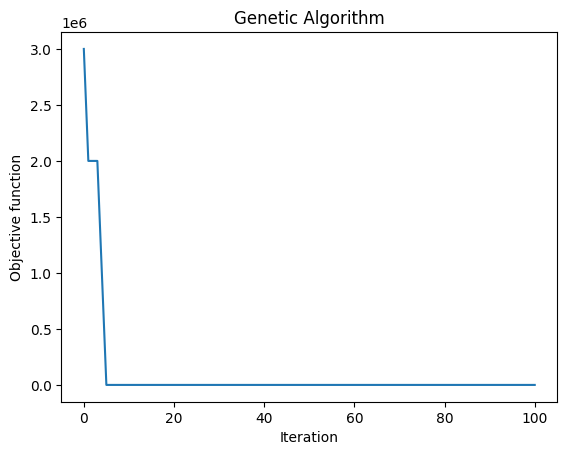


--- Run 12 ---
 The best solution found:                                                                           
 [25. 17.  1.  0.  6. 22.  3.  0. 14. 23.  2.  0. 24. 25.  3.  0. 12.  4.
  2.  0.  2.  3.  0.  1.  2. 27.  2.  0. 20. 28.  1.  0. 19. 10.  2.  0.
  8. 25.  3.  1. 27.  6.  1.  0.  5. 13.  0.  0. 23. 28.  2.  1. 10.  8.
  1.  0. 10.  2.  2.  0. 28. 14.  3.  0.  0. 17.  2.  0.  1. 17.  0.  0.
 17.  9.  1.  1.  4. 12.  0.  0. 10.  7.  0.  0. 27. 28.  3.  0. 19.  8.
  3.  0. 17. 12.  2.  0.  1. 11.  2.  1. 10. 14.  2.  0. 22. 14.  1.  0.
 20.  8.  0.  0.  3. 26.  2.  0. 17. 22.  3.  1.  6. 13.  0.  1.  5. 10.
  2.  1. 21. 23.  0.  1. 26. 10.  3.  0.  9.  2.  2.  0. 16.  2.  3.  1.
 25.  3.  3.  0.  5. 27.  2.  0. 21. 22.  3.  1. 22.  0.  2.  0.  1.  7.
  0.  0.  3.  4.  3.  0. 19. 25.  2.  1. 22. 18.  3.  1. 15. 26.  3.  0.
 24. 27.  1.  0. 11.  1.  1.  0. 14.  9.  0.  0.  4. 11.  2.  0. 10. 22.
  3.  0.]

 Objective function:
 42.5828861773659


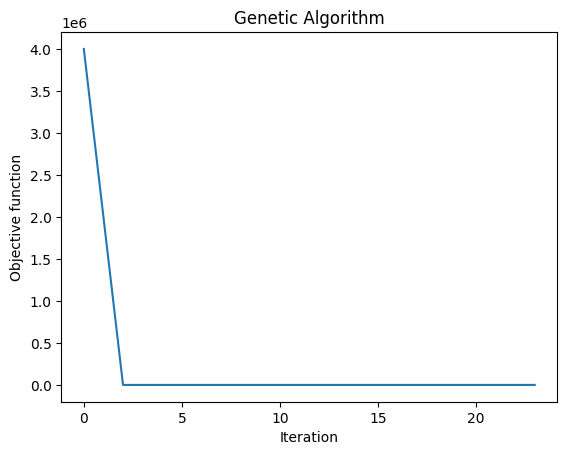


--- Run 13 ---
 The best solution found:                                                                           
 [14. 13.  3.  0.  3. 15.  2.  1. 19.  6.  2.  1. 13. 21.  1.  0. 19. 10.
  1.  0. 20. 24.  0.  0. 26. 18.  3.  0. 14.  6.  2.  0. 19. 28.  0.  1.
 12.  3.  1.  1. 28. 10.  3.  1. 19. 21.  1.  0. 19. 17.  2.  0. 20. 19.
  2.  1. 13.  4.  3.  0.  6. 24.  0.  1.  4. 19.  2.  0.  6.  6.  2.  0.
  8. 27.  0.  1.  0.  1.  2.  0. 12. 17.  1.  0.  1.  3.  0.  1. 28. 22.
  3.  0. 28. 25.  0.  1. 26.  7.  3.  0. 14. 11.  2.  0. 17.  8.  1.  1.
 16. 19.  0.  1. 17. 28.  1.  0.  9. 27.  1.  0. 18. 22.  2.  0.  8.  6.
  0.  0.  2. 14.  3.  0. 11. 13.  3.  1. 18. 12.  1.  0.  3. 15.  0.  0.
 15. 26.  2.  0. 14. 17.  2.  0. 27.  9.  2.  1. 15.  7.  2.  0.  6.  0.
  0.  1. 23. 23.  3.  0. 11.  1.  1.  1. 21.  1.  2.  0.  5. 26.  3.  0.
 26.  8.  3.  0.  2. 18.  3.  0. 20.  6.  3.  0. 15. 10.  0.  1. 20.  6.
  2.  0.]

 Objective function:
 42.580852992068316


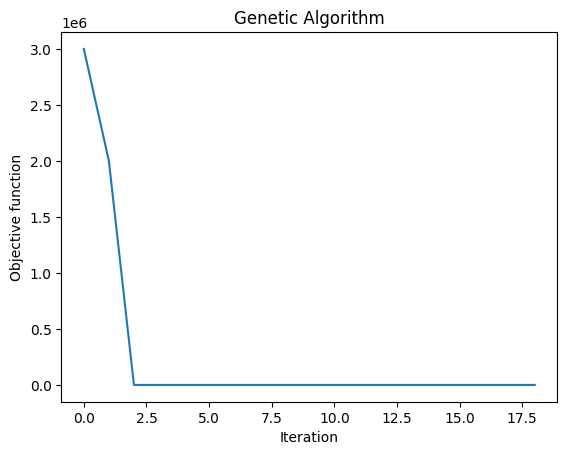


--- Run 14 ---
 The best solution found:                                                                           
 [ 4. 15.  3.  1.  9.  1.  1.  1. 17. 14.  3.  1. 23. 18.  1.  0. 24. 19.
  2.  0. 23.  7.  0.  0. 14. 12.  3.  0.  0. 16.  3.  0. 10. 22.  0.  1.
 17. 14.  0.  0. 27. 14.  1.  0. 17.  6.  3.  1. 21. 19.  2.  0.  8. 24.
  2.  0. 24.  0.  0.  0. 14. 22.  0.  0. 10. 15.  2.  1. 14.  8.  1.  0.
  1.  0.  2.  0. 13.  8.  2.  0.  3.  4.  2.  0. 18.  0.  3.  1. 21. 17.
  0.  1. 15.  6.  0.  0. 16. 11.  0.  0. 18.  8.  1.  0. 25.  6.  2.  0.
 12. 15.  1.  1. 10.  6.  2.  0. 16. 16.  0.  1.  2. 12.  0.  1. 25.  8.
  1.  1. 28.  9.  0.  0. 12.  6.  1.  1. 16.  8.  0.  1. 12. 24.  0.  0.
 16. 13.  0.  0. 25. 28.  1.  0. 21. 14.  1.  0. 22. 24.  2.  0. 24.  0.
  0.  1. 17.  0.  1.  0. 26.  5.  2.  0. 12.  5.  0.  1.  1.  0.  2.  0.
 10. 18.  1.  0. 27.  5.  2.  0. 23. 17.  0.  0. 23. 14.  1.  0.  2.  4.
  0.  0.]

 Objective function:
 42.43926417416788


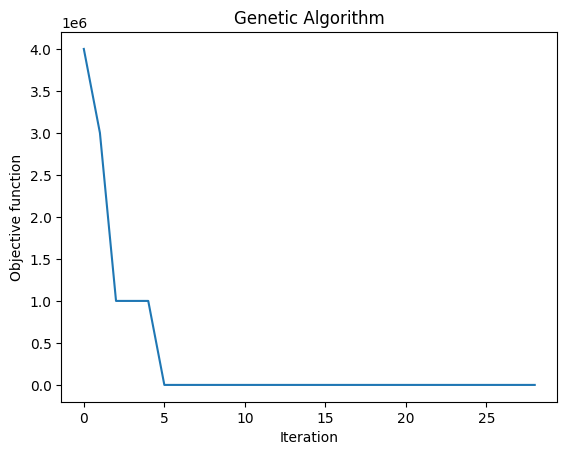


--- Run 15 ---
 The best solution found:                                                                           
 [ 2. 17.  2.  0. 17. 23.  1.  0.  8. 16.  0.  0. 17. 17.  0.  1. 25.  9.
  0.  0. 16. 12.  3.  0.  7. 24.  1.  1.  8. 20.  1.  1. 21. 20.  0.  0.
  7. 26.  0.  1. 25. 14.  2.  1.  9. 20.  2.  0.  4. 25.  1.  0. 18.  9.
  1.  0. 15.  7.  3.  0.  5.  9.  1.  1. 16. 16.  1.  0. 19. 11.  0.  1.
 18.  2.  2.  0. 15. 25.  0.  1. 18. 22.  0.  0. 13. 17.  1.  0. 23. 18.
  3.  0. 14. 16.  0.  0. 10.  7.  2.  0.  6. 24.  0.  0. 25.  6.  0.  1.
  1. 28.  0.  1. 11. 11.  0.  1.  1. 18.  3.  0.  7.  7.  1.  0. 24.  9.
  0.  0. 13.  4.  0.  1.  0. 28.  0.  1. 18. 14.  1.  0. 27. 11.  2.  0.
 22. 16.  1.  1. 27.  6.  0.  1. 22.  8.  2.  0. 11. 14.  2.  0. 17. 14.
  2.  0.  8. 14.  0.  1.  4. 14.  1.  1. 11. 12.  1.  0. 23.  8.  3.  0.
  6.  2.  2.  0. 25.  6.  0.  0. 12. 22.  0.  1.  8.  0.  2.  0.  5. 19.
  2.  1.]

 Objective function:
 42.21726928356418


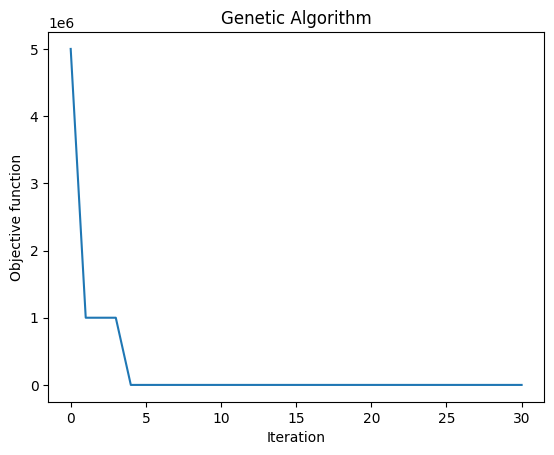


--- Run 16 ---
 The best solution found:                                                                           
 [ 4. 27.  3.  0. 10.  7.  3.  1.  7.  2.  1.  1. 16.  9.  0.  1.  2. 21.
  2.  0. 22.  8.  3.  1. 10. 11.  1.  0.  7. 18.  1.  0.  2.  6.  1.  0.
 19. 20.  0.  0. 21. 23.  2.  1. 22.  7.  3.  1. 22. 14.  0.  0. 11. 17.
  0.  1.  1. 21.  2.  0.  3.  7.  3.  0. 19. 24.  0.  0. 23. 24.  2.  0.
 27. 12.  2.  0. 28.  4.  2.  0. 10. 11.  1.  0.  1. 23.  0.  0. 14.  7.
  2.  0. 21. 23.  3.  0. 17. 18.  1.  0. 24.  2.  1.  1. 21. 18.  0.  1.
  8.  9.  3.  1.  2. 27.  2.  0. 16. 15.  0.  0.  2. 20.  2.  0. 15. 15.
  2.  0. 15. 20.  3.  0.  4. 21.  2.  0. 12. 11.  3.  0.  6.  2.  3.  0.
 17. 26.  2.  0. 19. 13.  0.  1.  2. 18.  1.  0.  7. 21.  2.  0. 25.  3.
  1.  0. 19. 12.  2.  0.  9. 23.  0.  1. 10. 15.  3.  0. 27. 25.  1.  0.
  3. 28.  2.  0. 11. 12.  3.  1. 28. 20.  1.  0. 11. 11.  3.  1.  8. 14.
  3.  0.]

 Objective function:
 42.2990581184238


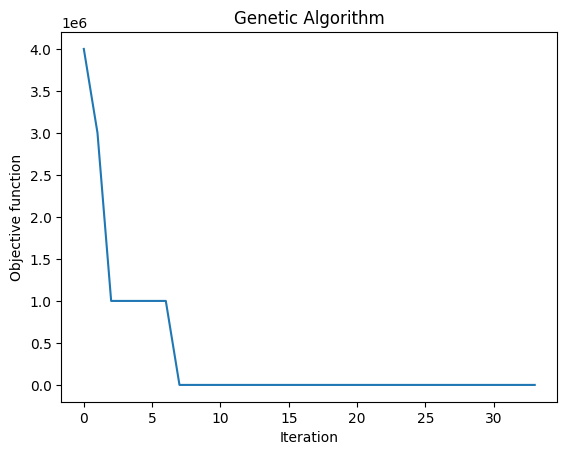


--- Run 17 ---
 The best solution found:                                                                           
 [ 6. 24.  0.  0. 13.  6.  0.  1.  2.  4.  1.  1.  2. 26.  0.  1. 11. 13.
  0.  1. 16. 26.  2.  0. 21.  4.  0.  1. 21.  6.  0.  0. 28. 13.  2.  0.
 24. 12.  1.  0. 11. 13.  2.  0.  8. 26.  2.  0.  5. 19.  3.  0. 13.  7.
  2.  0.  5. 26.  0.  0. 19.  1.  3.  0. 16. 10.  2.  0. 20. 25.  2.  0.
 25. 13.  3.  0.  2.  4.  1.  0.  2.  4.  0.  0. 25. 13.  0.  0.  3. 15.
  3.  1.  5. 22.  1.  0.  2. 24.  3.  1. 13. 20.  0.  1. 19. 23.  1.  0.
 13.  8.  0.  1. 24.  6.  3.  1. 12.  9.  0.  1. 19.  8.  3.  0. 18. 17.
  0.  1. 26. 15.  1.  0. 28. 27.  1.  1. 19. 12.  1.  1.  9. 24.  3.  0.
  0.  8.  2.  1. 22. 25.  3.  0. 28.  9.  1.  0. 17. 17.  0.  0.  5. 10.
  3.  0. 22. 16.  0.  1.  9. 19.  2.  1. 15.  5.  1.  0. 22. 16.  3.  0.
 22. 12.  3.  0.  6.  2.  1.  0. 24.  1.  0.  0. 22.  7.  1.  0.  0.  0.
  3.  0.]

 Objective function:
 42.44008108532754


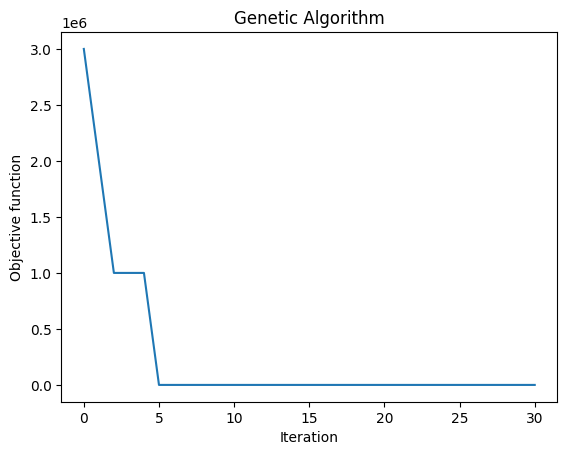


--- Run 18 ---
 The best solution found:                                                                           
 [16. 17.  2.  0. 16. 28.  3.  0. 15.  3.  1.  0. 14. 18.  2.  1. 18. 22.
  0.  1.  0.  7.  3.  0. 14. 13.  2.  0. 18. 11.  3.  1. 25. 13.  1.  0.
 19. 20.  2.  0.  0.  9.  2.  0. 16.  9.  1.  0. 16.  2.  3.  1. 13. 22.
  1.  1. 21. 17.  2.  1. 24.  3.  0.  0.  0. 19.  2.  0. 12. 20.  1.  1.
 15. 17.  2.  0.  9. 23.  1.  0. 23. 15.  0.  0. 17. 26.  3.  0.  1. 11.
  0.  0. 26. 23.  1.  0. 15. 24.  2.  0.  8. 21.  0.  0.  7. 16.  0.  1.
  8. 11.  1.  0. 22. 15.  0.  1. 21. 17.  3.  0. 26. 11.  0.  0. 14. 10.
  3.  1.  3. 18.  0.  0. 15. 28.  0.  0. 15.  2.  3.  0. 19.  7.  1.  0.
 21. 24.  3.  1. 25.  9.  3.  0.  3. 22.  0.  1.  4. 16.  1.  0.  1. 24.
  2.  0. 23. 18.  1.  0. 10. 28.  3.  0.  7.  2.  3.  0.  6. 26.  0.  0.
 20. 18.  2.  0. 10.  6.  2.  1. 20. 11.  1.  0. 22. 15.  1.  0.  3. 12.
  1.  0.]

 Objective function:
 42.38561918220646


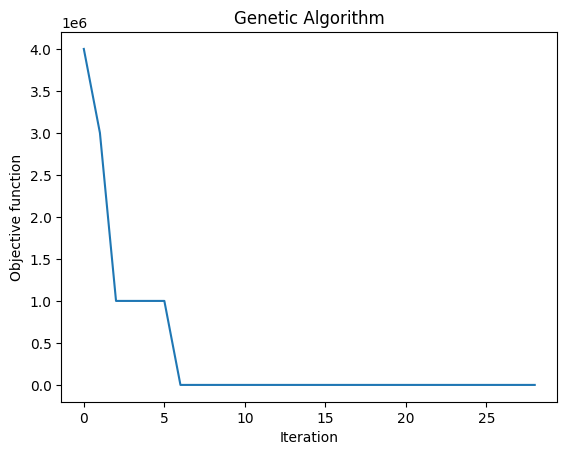


--- Run 19 ---
 The best solution found:                                                                           
 [ 8. 28.  0.  0. 12.  4.  1.  0. 23. 19.  2.  0. 24.  6.  0.  1.  4. 13.
  1.  0. 13. 14.  3.  0. 25.  8.  3.  0. 24.  8.  0.  1. 14. 10.  0.  1.
 17. 10.  3.  1.  5.  8.  3.  0.  7.  5.  3.  0. 14.  9.  1.  0. 20.  4.
  3.  0. 24.  7.  2.  1. 26. 17.  0.  1.  1.  6.  0.  1. 10. 20.  0.  0.
  0.  9.  2.  1. 18. 22.  1.  0.  8. 21.  2.  0.  5. 19.  2.  0. 16. 22.
  3.  1. 19. 12.  1.  0. 14.  0.  1.  0. 10.  6.  1.  1. 10. 18.  2.  0.
 11. 21.  2.  0. 26. 10.  0.  0. 15. 16.  1.  0. 18. 18.  0.  1. 16.  9.
  0.  1. 19.  6.  3.  0.  6.  3.  0.  0.  5. 22.  2.  0.  5. 22.  0.  0.
  3. 26.  0.  1. 24. 23.  1.  1. 13. 23.  3.  0. 20. 24.  3.  0.  0. 24.
  2.  0. 11. 10.  3.  0. 23. 11.  1.  0. 16. 23.  3.  1.  5. 26.  3.  0.
  3. 14.  0.  0. 16. 10.  0.  0. 22. 28.  0.  0. 17. 17.  0.  1. 12.  2.
  0.  0.]

 Objective function:
 42.15224126882607


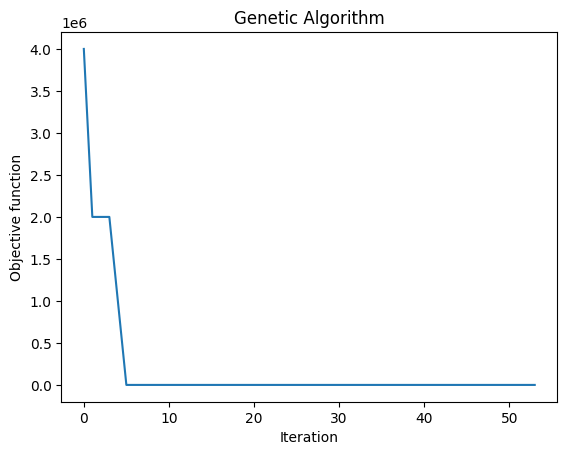


--- Run 20 ---
 The best solution found:                                                                           
 [17.  9.  0.  1. 22.  5.  0.  1. 22. 22.  3.  0. 15.  1.  0.  1. 11.  6.
  1.  0. 17.  1.  0.  1. 19.  4.  3.  0. 16. 15.  3.  0. 17.  5.  0.  1.
 22. 18.  3.  1. 16.  0.  1.  0. 24. 19.  0.  0. 20. 27.  2.  0.  8.  6.
  2.  0. 20. 12.  3.  0. 19. 16.  2.  0. 14. 20.  2.  0.  4.  7.  2.  0.
  0. 14.  0.  1. 16. 21.  0.  1.  7. 11.  3.  0.  0.  4.  0.  0. 19. 13.
  1.  0.  9.  4.  1.  0. 15. 14.  1.  1.  8. 20.  0.  0.  2. 16.  0.  1.
 19. 10.  0.  0. 11.  3.  1.  0. 13. 18.  2.  0.  1.  3.  2.  1.  8.  5.
  2.  0. 21. 21.  3.  1.  4. 13.  0.  1. 27. 13.  0.  0.  3. 12.  0.  0.
 16.  6.  0.  0. 17. 15.  0.  1. 10. 25.  1.  0.  9. 10.  0.  1.  8. 22.
  2.  1. 28. 21.  2.  0. 15. 15.  2.  0. 17. 21.  1.  0. 19. 21.  0.  1.
 28. 25.  0.  1. 16.  9.  1.  0. 12.  8.  0.  0. 14.  2.  0.  0. 27. 20.
  0.  0.]

 Objective function:
 42.06126056659781


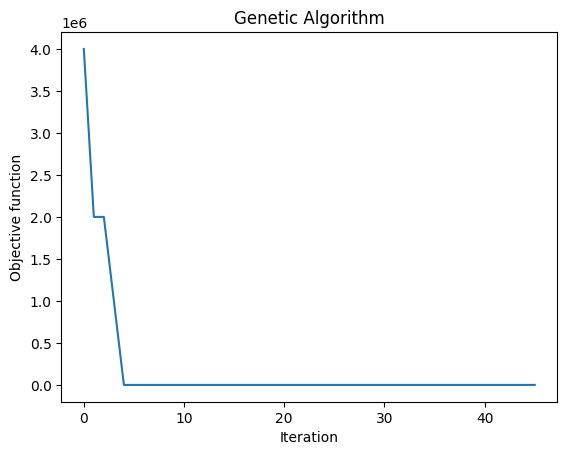


--- Run 21 ---
 The best solution found:                                                                           
 [ 2.  3.  1.  1. 27.  9.  0.  0.  3. 13.  1.  0. 27. 20.  1.  0. 24.  2.
  3.  0. 13. 20.  3.  1.  1.  3.  1.  0. 13. 15.  1.  0. 15. 11.  2.  1.
 28. 24.  0.  0. 21. 16.  0.  0. 17. 15.  2.  0.  2. 28.  2.  0. 10. 16.
  0.  0. 13. 18.  0.  1. 21. 24.  2.  0. 20. 15.  0.  1. 21.  4.  2.  0.
 22. 13.  2.  0. 25. 25.  1.  0. 12. 27.  1.  0.  8.  6.  0.  1.  3.  6.
  2.  0. 27. 28.  3.  0. 16. 21.  1.  1.  5. 21.  0.  0.  8. 22.  0.  0.
  2. 24.  0.  0.  3.  1.  0.  0. 19. 10.  2.  1. 24.  8.  2.  1. 17.  6.
  3.  0. 17. 24.  0.  1. 23.  3.  1.  0. 18. 14.  0.  1.  6.  1.  0.  1.
 25.  4.  0.  1.  6. 24.  1.  0. 12.  2.  0.  1. 18. 22.  3.  0. 16.  0.
  0.  0. 15.  3.  2.  0. 18.  6.  3.  0.  7. 27.  0.  0. 19. 10.  1.  0.
 24. 19.  2.  0.  2.  9.  2.  1. 19. 11.  0.  1. 13. 26.  2.  0. 20. 11.
  3.  0.]

 Objective function:
 42.24025854460476


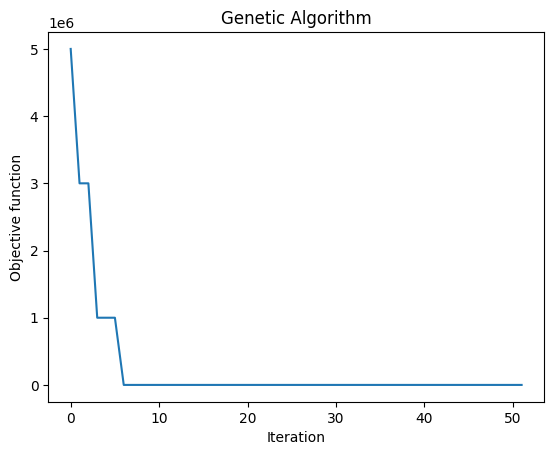


--- Run 22 ---
 The best solution found:                                                                           
 [ 8. 12.  0.  0. 21. 12.  3.  0.  5. 12.  1.  0. 19. 28.  0.  1. 15. 18.
  1.  0. 11.  6.  2.  0. 22.  7.  0.  1.  0.  1.  3.  0. 16. 22.  2.  0.
 23. 17.  3.  0. 22.  0.  2.  0.  2. 13.  3.  0.  9. 21.  0.  1. 11. 15.
  0.  1. 11. 13.  2.  0. 21. 24.  0.  1.  4. 24.  3.  0. 10. 14.  0.  1.
 17.  2.  0.  0. 10.  9.  0.  1.  5. 15.  1.  0. 20.  7.  3.  0. 12. 16.
  0.  1. 18.  2.  3.  1.  1. 15.  1.  0.  3. 23.  2.  0.  1. 11.  1.  1.
 13. 19.  0.  1. 19.  0.  1.  1. 19. 20.  1.  0.  2.  9.  0.  0. 27. 24.
  0.  0.  2.  6.  1.  0.  1. 19.  0.  0. 12. 14.  0.  1. 17.  5.  2.  0.
  7.  5.  3.  0.  1.  3.  0.  0. 16. 13.  0.  1.  7.  9.  1.  0. 18. 13.
  2.  0. 13. 10.  3.  0. 10. 19.  0.  1. 12. 10.  0.  1. 26.  0.  3.  0.
 15.  2.  1.  0.  3. 19.  3.  0.  6.  0.  2.  1. 15. 10.  1.  1. 24. 16.
  2.  1.]

 Objective function:
 42.0344838421581


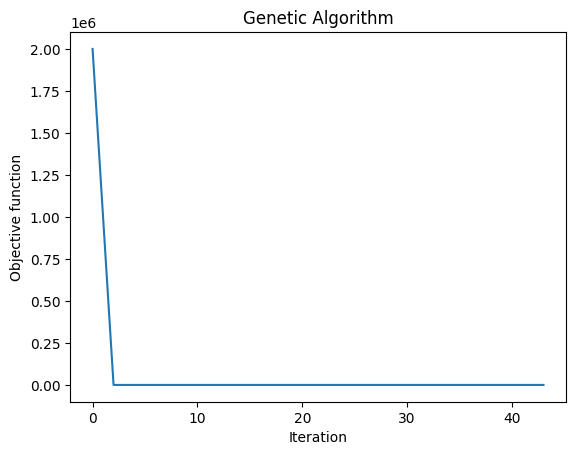


--- Run 23 ---
 The best solution found:                                                                           
 [10.  6.  3.  0. 17. 14.  2.  0. 16.  2.  0.  0. 28. 12.  1.  0. 16.  8.
  1.  0.  2. 20.  2.  0.  7. 15.  2.  0.  0.  9.  3.  0. 15. 14.  2.  0.
 22. 18.  0.  0. 22. 10.  0.  0. 23. 24.  1.  0.  8. 17.  3.  1. 24. 22.
  1.  0. 27. 19.  3.  0. 27. 23.  1.  0. 24. 17.  3.  1. 24. 18.  0.  0.
  2. 21.  3.  0.  7. 15.  1.  0. 14. 19.  3.  0. 22. 16.  2.  1. 21.  0.
  2.  0.  5. 25.  3.  0. 18. 15.  1.  0. 17.  6.  3.  0. 11. 10.  0.  1.
 22. 11.  2.  0.  3. 19.  1.  0. 12. 19.  3.  1.  9. 22.  1.  0.  3. 16.
  1.  0. 28. 14.  0.  0.  3. 16.  0.  1.  3.  7.  3.  0.  0.  1.  2.  1.
 16. 23.  0.  1.  2. 22.  1.  0.  4. 12.  2.  1. 14.  3.  2.  0.  9. 14.
  2.  1. 20.  3.  1.  1. 20.  1.  2.  0.  3.  0.  3.  0. 24.  7.  1.  1.
  4.  4.  2.  1.  7. 13.  1.  1.  7. 13.  1.  0.  7. 10.  0.  0.  6. 15.
  2.  0.]

 Objective function:
 42.58778028558577


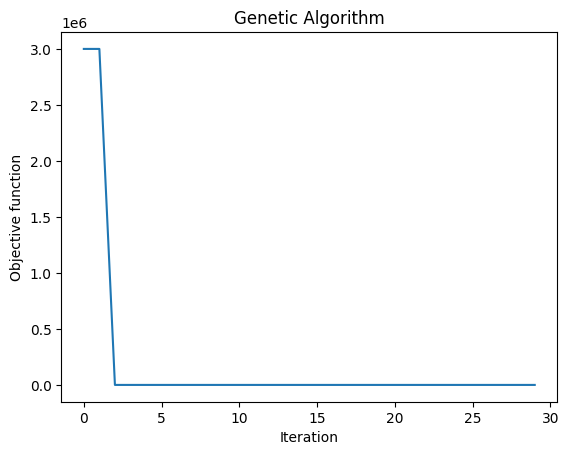


--- Run 24 ---
 The best solution found:                                                                           
 [ 4. 14.  0.  0.  7. 28.  3.  0. 25.  7.  3.  0. 12. 14.  2.  0. 11. 21.
  3.  1. 21. 19.  0.  1. 14.  7.  2.  1. 17. 25.  1.  0.  9. 28.  2.  1.
 12. 15.  0.  0. 13. 11.  3.  0. 10. 12.  0.  0. 27. 14.  2.  0.  9.  6.
  1.  1.  2. 11.  1.  0. 18. 27.  0.  0. 19. 13.  0.  0. 16. 28.  3.  0.
 25. 16.  2.  0.  9. 15.  2.  0. 18. 26.  0.  0. 15. 11.  3.  0. 28.  4.
  2.  0. 19. 28.  1.  0. 12.  6.  1.  0.  0.  9.  2.  1.  7. 13.  3.  0.
  8. 14.  0.  1.  7. 26.  0.  1. 11. 23.  3.  0. 23. 25.  3.  1. 10.  0.
  0.  1. 27.  8.  2.  1. 12.  7.  0.  0.  9.  8.  0.  0. 23.  1.  0.  0.
 12.  7.  0.  0. 27. 12.  2.  0. 18. 12.  2.  1. 19.  4.  0.  0. 16. 13.
  2.  1. 12.  8.  0.  0. 24. 26.  1.  0. 22. 15.  3.  1. 10. 11.  0.  0.
 15.  6.  2.  0.  6. 27.  0.  0. 25.  5.  0.  0. 24.  8.  2.  0. 25. 10.
  3.  0.]

 Objective function:
 42.5661006617028


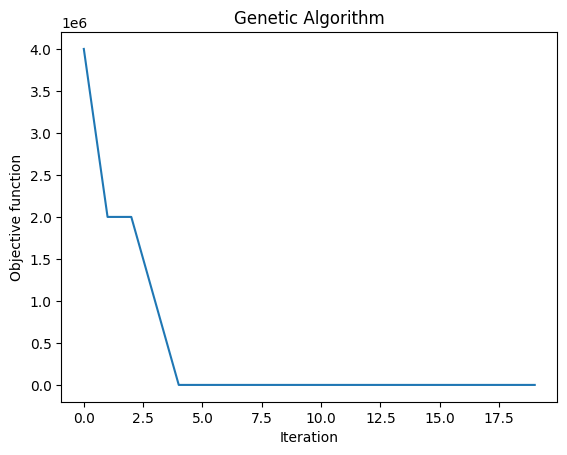


--- Run 25 ---
 The best solution found:                                                                           
 [ 5. 19.  0.  0. 12. 17.  1.  0. 14. 11.  1.  0. 16.  6.  0.  1. 18.  8.
  0.  1.  9. 11.  0.  1. 19. 15.  0.  1.  1.  8.  3.  0.  7.  8.  0.  1.
 28.  0.  2.  0. 22. 18.  0.  1.  2. 22.  0.  0. 16. 21.  3.  0. 24. 27.
  0.  0.  1. 15.  3.  0. 22.  8.  0.  1.  7. 12.  0.  0. 15.  8.  2.  1.
  7. 23.  0.  1.  8.  8.  0.  0. 11.  1.  0.  1. 20. 22.  2.  1.  3. 20.
  1.  0.  8. 15.  1.  0. 19. 10.  0.  1.  7. 24.  3.  0.  7.  2.  1.  0.
 17. 19.  1.  0.  9. 28.  0.  1. 22.  2.  1.  0.  9. 10.  2.  1.  8. 22.
  0.  1. 27.  9.  2.  0.  4.  0.  0.  0.  9. 10.  2.  0. 22.  9.  0.  0.
  5. 24.  3.  0. 23. 22.  0.  0.  9. 25.  2.  0.  6. 19.  2.  0.  5. 24.
  3.  0. 18.  3.  2.  0. 19. 27.  2.  1. 22.  6.  1.  0.  5. 12.  2.  0.
 18. 12.  2.  1. 17. 17.  0.  1. 17.  1.  2.  0. 11. 22.  0.  0. 16. 24.
  1.  0.]

 Objective function:
 41.86328360963488


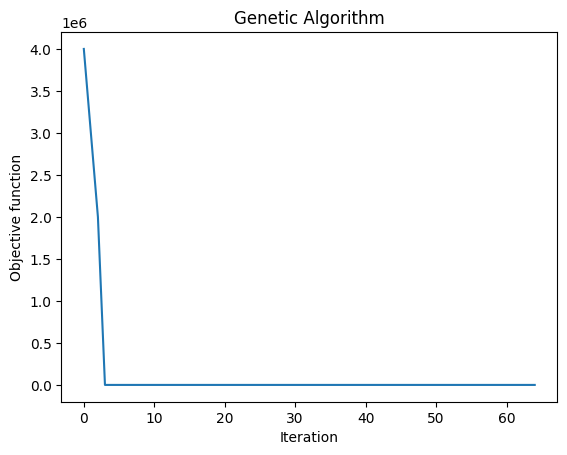


✅ Evaluation completed.


In [11]:
stats = evaluate_multiple_runs(runs=25,
                               type_matrix=type_matrix,
                               temp_matrix=temp_matrix,
                               budget_max=budget_max,
                               type_to_num=type_to_num,
                               tree_species=tree_species)


=== Summary Table ===
          Algorithm  Mean Budget  Std Budget  Mean Avg Temp  Std Avg Temp  \
0  Random Insertion       1481.8       13.99          28.65          0.10   
1                GA       1474.6       18.86          28.36          0.13   
2               ACO       1485.2       17.52          28.41          0.13   
3     ACO + Cand Ph       1485.2       11.44          28.39          0.13   

   Mean Hotspot Temp  Std Hotspot Temp  
0              31.78              0.23  
1              31.07              0.30  
2              31.64              0.21  
3              31.70              0.31  


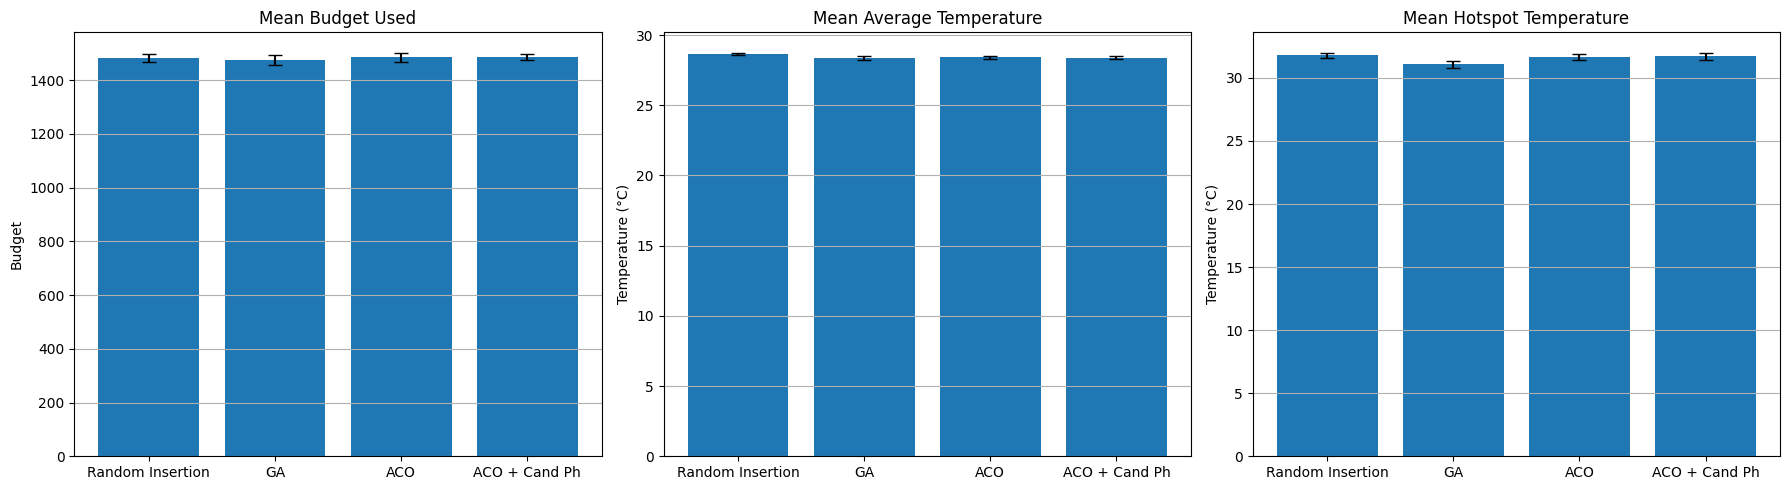

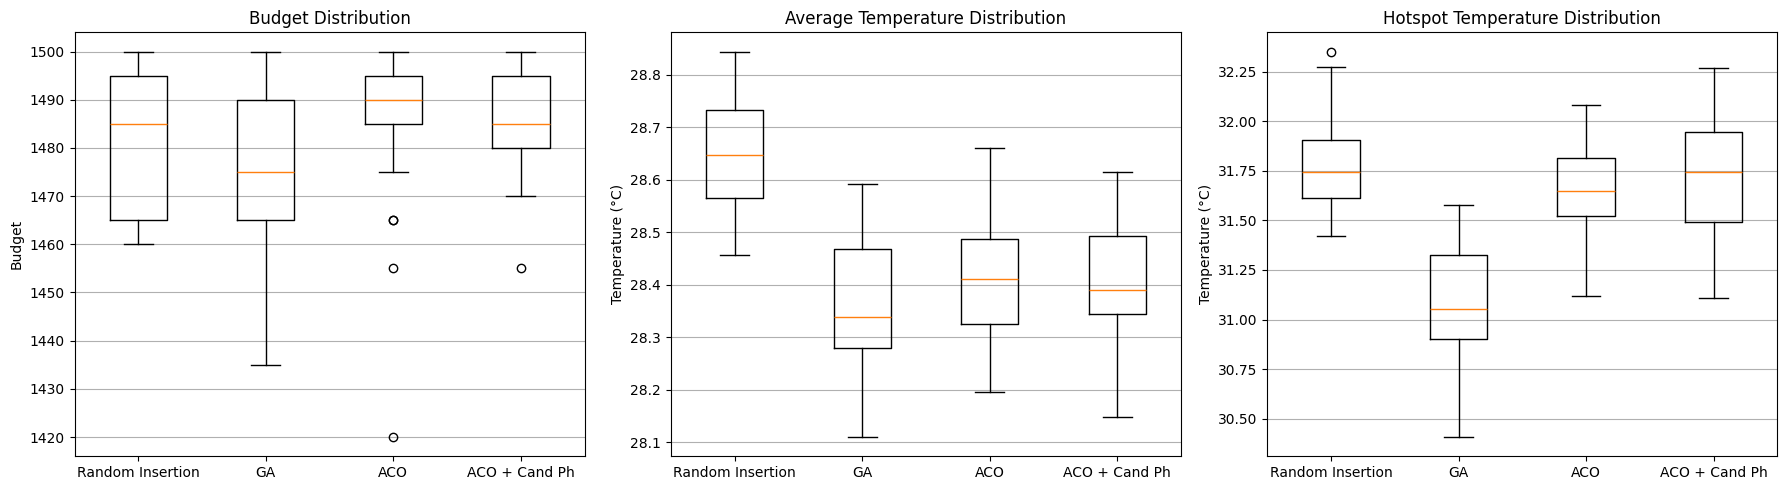

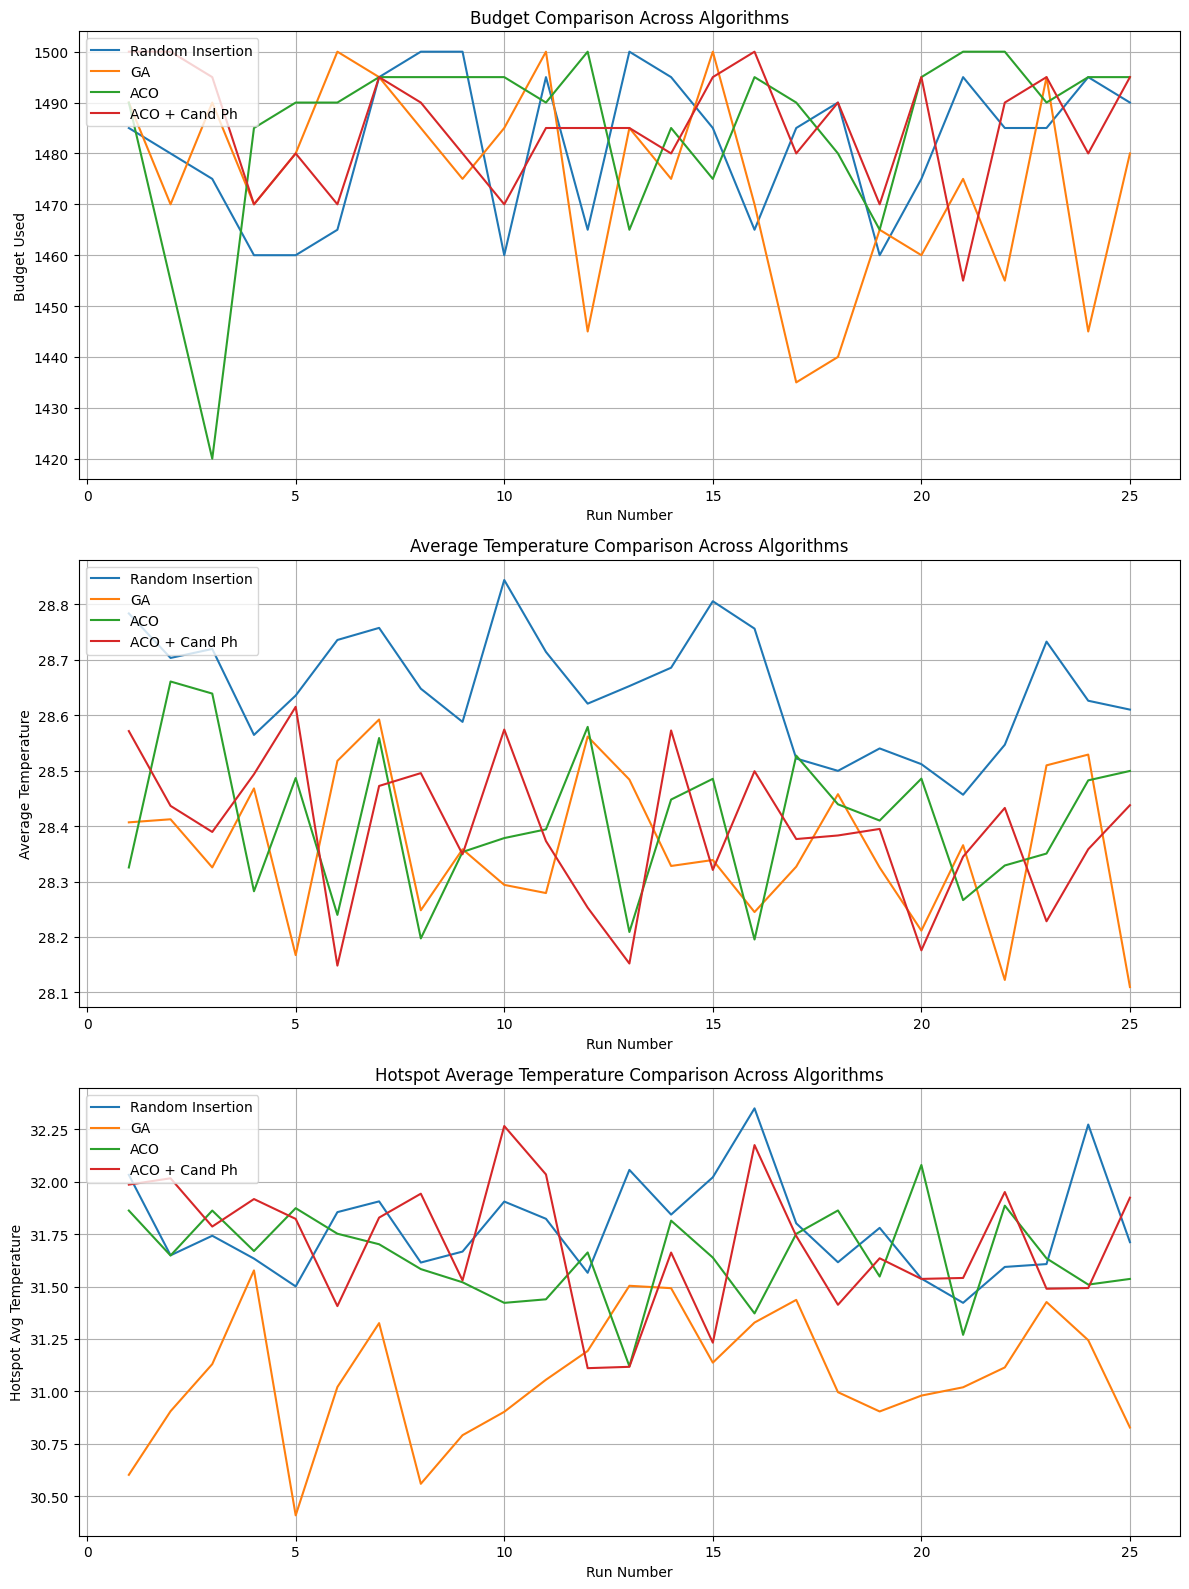

In [12]:
algorithms = ['Random Insertion', 'GA', 'ACO', 'ACO + Cand Ph'] 
summary_df = summarize_algorithm_runs(stats, algorithms)


In [23]:
summary_df

,Algorithm,Mean Budget,Std Budget,Mean Avg Temp,Std Avg Temp,Mean Hotspot Temp,Std Hotspot Temp
0,Random Insertion,1480.8,14.675149,28.630665,0.123224,31.826269,0.221215
1,GA,1474.8,37.907255,28.517082,0.121826,31.465976,0.299371
2,ACO,1488.2,10.087616,28.450456,0.112894,31.726346,0.255847
3,ACO + Cand Ph,1489.8,10.533755,28.257601,0.152744,31.454589,0.254702
